In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

import scipy
from scipy import signal,stats
from scipy.fft import rfft,rfftfreq
from scipy import stats
from scipy.ndimage import uniform_filter1d

import seaborn as sns
import pandas as pd
import sklearn
import seaborn as sns

From Luisa use 'Happy_0_Meisner.txt' (happy), 'Relaxed_9.txt' (relaxed), 'Tense_0_Meisner.txt' (tense), 'Sad_0_Maisner.txt' (sad)
From Antonio use 'Erotic_5.txt' (happy), 'Scenery_2.txt' (relaxed), 'Fear 2_1.txt' (tense), 'Sadness_7.txt' (sad)

EEG0: on RIGHT Mastoid Bone
EEG1: on RIGHT Frontal AF8
EEG2: on LEFT Frontal AF7
EEG3: on LEFT Mastoid Bone

In [ ]:
# # Create function to load data 

filenames = ['Happy_0_Meisner.txt', 'Tense_0_Meisner.txt', 'Relaxed_9.txt', 'Sad_0_Maisner.txt'] 

filenames_antonio = ['Erotic_5.txt', 'Fear 2_1.txt', 'Scenery_2.txt', 'Sadness_7.txt']

luisa_data = {'Happy':[],
              'Tense':[],
              'Relaxed':[],
              'Sad':[]}

antonio_data = {'Happy':[],
              'Tense':[],
              'Relaxed':[],
              'Sad':[]}


channels = ['0','1','2','3']

def load_data(file_path):
    data_file = pd.read_csv(file_path, comment='%', header=0, delimiter=',', engine='python') 
    data = data_file[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3']].values.T
    return data

# # Load Luisa data
print('Luisa Data:\n')
for idx, (state, _) in enumerate(luisa_data.items()):
    luisa_data[state] = load_data(f'.../Subject 6 Luisa/{filenames[idx]}')
    print(f'{state} Data Shape: {luisa_data[state].shape}')

# # Load Antonio data
print('\nAntonio Data:\n')
for idx, (state, _) in enumerate(antonio_data.items()):
    antonio_data[state] = load_data(f'.../Subject 3 Antonio/{filenames_antonio[idx]}')
    print(f'{state} Data Shape: {antonio_data[state].shape}')

antonio_data = {state : antonio_data[state][:,int(20*256):] for state in antonio_data.keys()} # Remove first 10 seconds of antonio data (artifact)


Luisa Data:

Happy Data Shape: (4, 18883)
Tense Data Shape: (4, 37779)
Relaxed Data Shape: (4, 18036)
Sad Data Shape: (4, 45879)

Antonio Data:

Happy Data Shape: (4, 24452)
Tense Data Shape: (4, 26844)
Relaxed Data Shape: (4, 26677)
Sad Data Shape: (4, 24321)


In [4]:
# # Remove outliers by using interpolation

for state, data in luisa_data.items():
    for i, ch in enumerate(data):
        luisa_mask = abs(ch - np.mean(ch)) > 2 * np.std(ch) # Identify outliers
        
        # Replace outliers using linear interpolation
        indices = np.arange(len(ch)) 
        ch_cleaned = np.copy(ch)
        ch_cleaned[luisa_mask] = np.interp(indices[luisa_mask], indices[~luisa_mask], ch[~luisa_mask])
        
        luisa_data[state][i] = ch_cleaned


for state, data in antonio_data.items():
    for i, ch in enumerate(data):
        antonio_mask = abs(ch - np.mean(ch)) > 2 * np.std(ch) 
        
        indices = np.arange(len(ch)) 
        ch_cleaned = np.copy(ch)
        ch_cleaned[antonio_mask] = np.interp(indices[antonio_mask], indices[~antonio_mask], ch[~antonio_mask])
        
        antonio_data[state][i] = ch_cleaned


In [5]:
# # Set sampling frequency
fs = 200

# def notch_filter(data, freq, fs, Q=30):
#     nyquist = 0.5 * fs
#     w0 = freq / nyquist
#     b, a = signal.iirnotch(w0, Q)
#     return signal.filtfilt(b, a, data)


# Apply a bandpass filter between 4-60 Hz to each set of data
filt_coef = signal.firwin(numtaps=(int(3*fs/4)), cutoff=(4,55), fs=fs, pass_zero=False)

# # # Apply a bandstop filter between 40-90 Hz to each data set
# def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = signal.butter(order, [low, high], btype='band')
#     return signal.filtfilt(b, a, data)

# # # Filter luisa data using bandstop filter
# for state, data in luisa_data.items():
#     luisa_data[state] = bandstop_filter(data)

# # # Filter luisa data
# for state, data in antonio_data.items():
#     antonio_data[state] = bandstop_filter(data)

# # Filter luisa data
for state, data in luisa_data.items():
    luisa_data[state] = signal.lfilter(filt_coef,1.0,data, axis=-1)

# # Filter antonio data
for state, data in antonio_data.items():
    antonio_data[state] = signal.lfilter(filt_coef,1.0,data, axis=-1)



In [6]:
# # Create plotting functon for time and freq domain and plot Luisa data
def plot_subject_data(data,fs,channels,power_ylim=None):
    """
    Plot time-domain and power spectrum for each emotional state in a subjects dataset

    Parameters:
    data : dict
        Dictionary containing EEG data for each emotional state
    fs : int
        Sampling freq
    channels : list
        List of channel labels

    Returns:
    freq_domain_data : dict
        Dictionary containing power spectra and frequencies for each state and channel
    """
    n_states = len(data)
    freq_domain_data = {} # Initialze dict so you can store freq domain info for each state and each channel
    fig, axes = plt.subplots(2, n_states, figsize=(30, 16))
    fig.suptitle("Time-Domain and Power Spectra for All States", fontsize=24,fontweight='bold')


    for col, (state, data) in enumerate(data.items()):
        # Create time vector for current state
        t_vec = np.arange(2, data.shape[1]/fs, 1/fs) # chop out first couple seconds for now, antonio data still shows early artifact
        
        # Initialize storage for this state's frequency data
        freq_domain_data[state] = {"frequencies": None, "power_spectra": []}

        # Plot time domain data
        for i, ch in enumerate(data):
            axes[0,col].plot(t_vec, ch[2*fs:], label=f'Channel {channels[i]}' if col == 0 else None)
        axes[0,col].set_title(f'{state} (Time Domain)', fontsize=16,fontweight='bold')
        axes[0,col].set_xlabel('Time (s)', fontsize=16,fontweight='bold')
        axes[0,col].set_ylabel('Voltage (uV)', fontsize=16,fontweight='bold')
        axes[0,col].set_xlim([None, t_vec[-1]+1/fs])
        axes[0,col].tick_params(axis='both', which='major', labelsize=16)

        # Plot frequency domain data (power spectrum)
        for ch in data:
            ft = abs(rfft(ch))
            ps = ft**2
            freqs = rfftfreq(ch.size, d=1/fs)
            axes[1,col].plot(freqs, ps)

            # Store frequency and power spectrum for each channel
            freq_domain_data[state]["frequencies"] = freqs
            freq_domain_data[state]["power_spectra"].append(ps)


        axes[1,col].set_title(f'{state} (Power Spectrum)', fontsize=16,fontweight='bold')
        axes[1,col].set_xlabel('Frequency (Hz)', fontsize=16,fontweight='bold')
        axes[1,col].set_ylabel('Power (Log Scale)', fontsize=16,fontweight='bold')
        axes[1,col].set_xlim([0.5, 60])
        axes[1,col].set_ylim([10e6, 10e9])
        axes[1,col].set_yscale('log')
        axes[1,col].grid(True, which='major')
        if power_ylim:
            axes[1, col].set_ylim(power_ylim) 
        axes[1, col].tick_params(axis='both', which='major', labelsize=16)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 0.5), fontsize=20, shadow=True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()

    return freq_domain_data


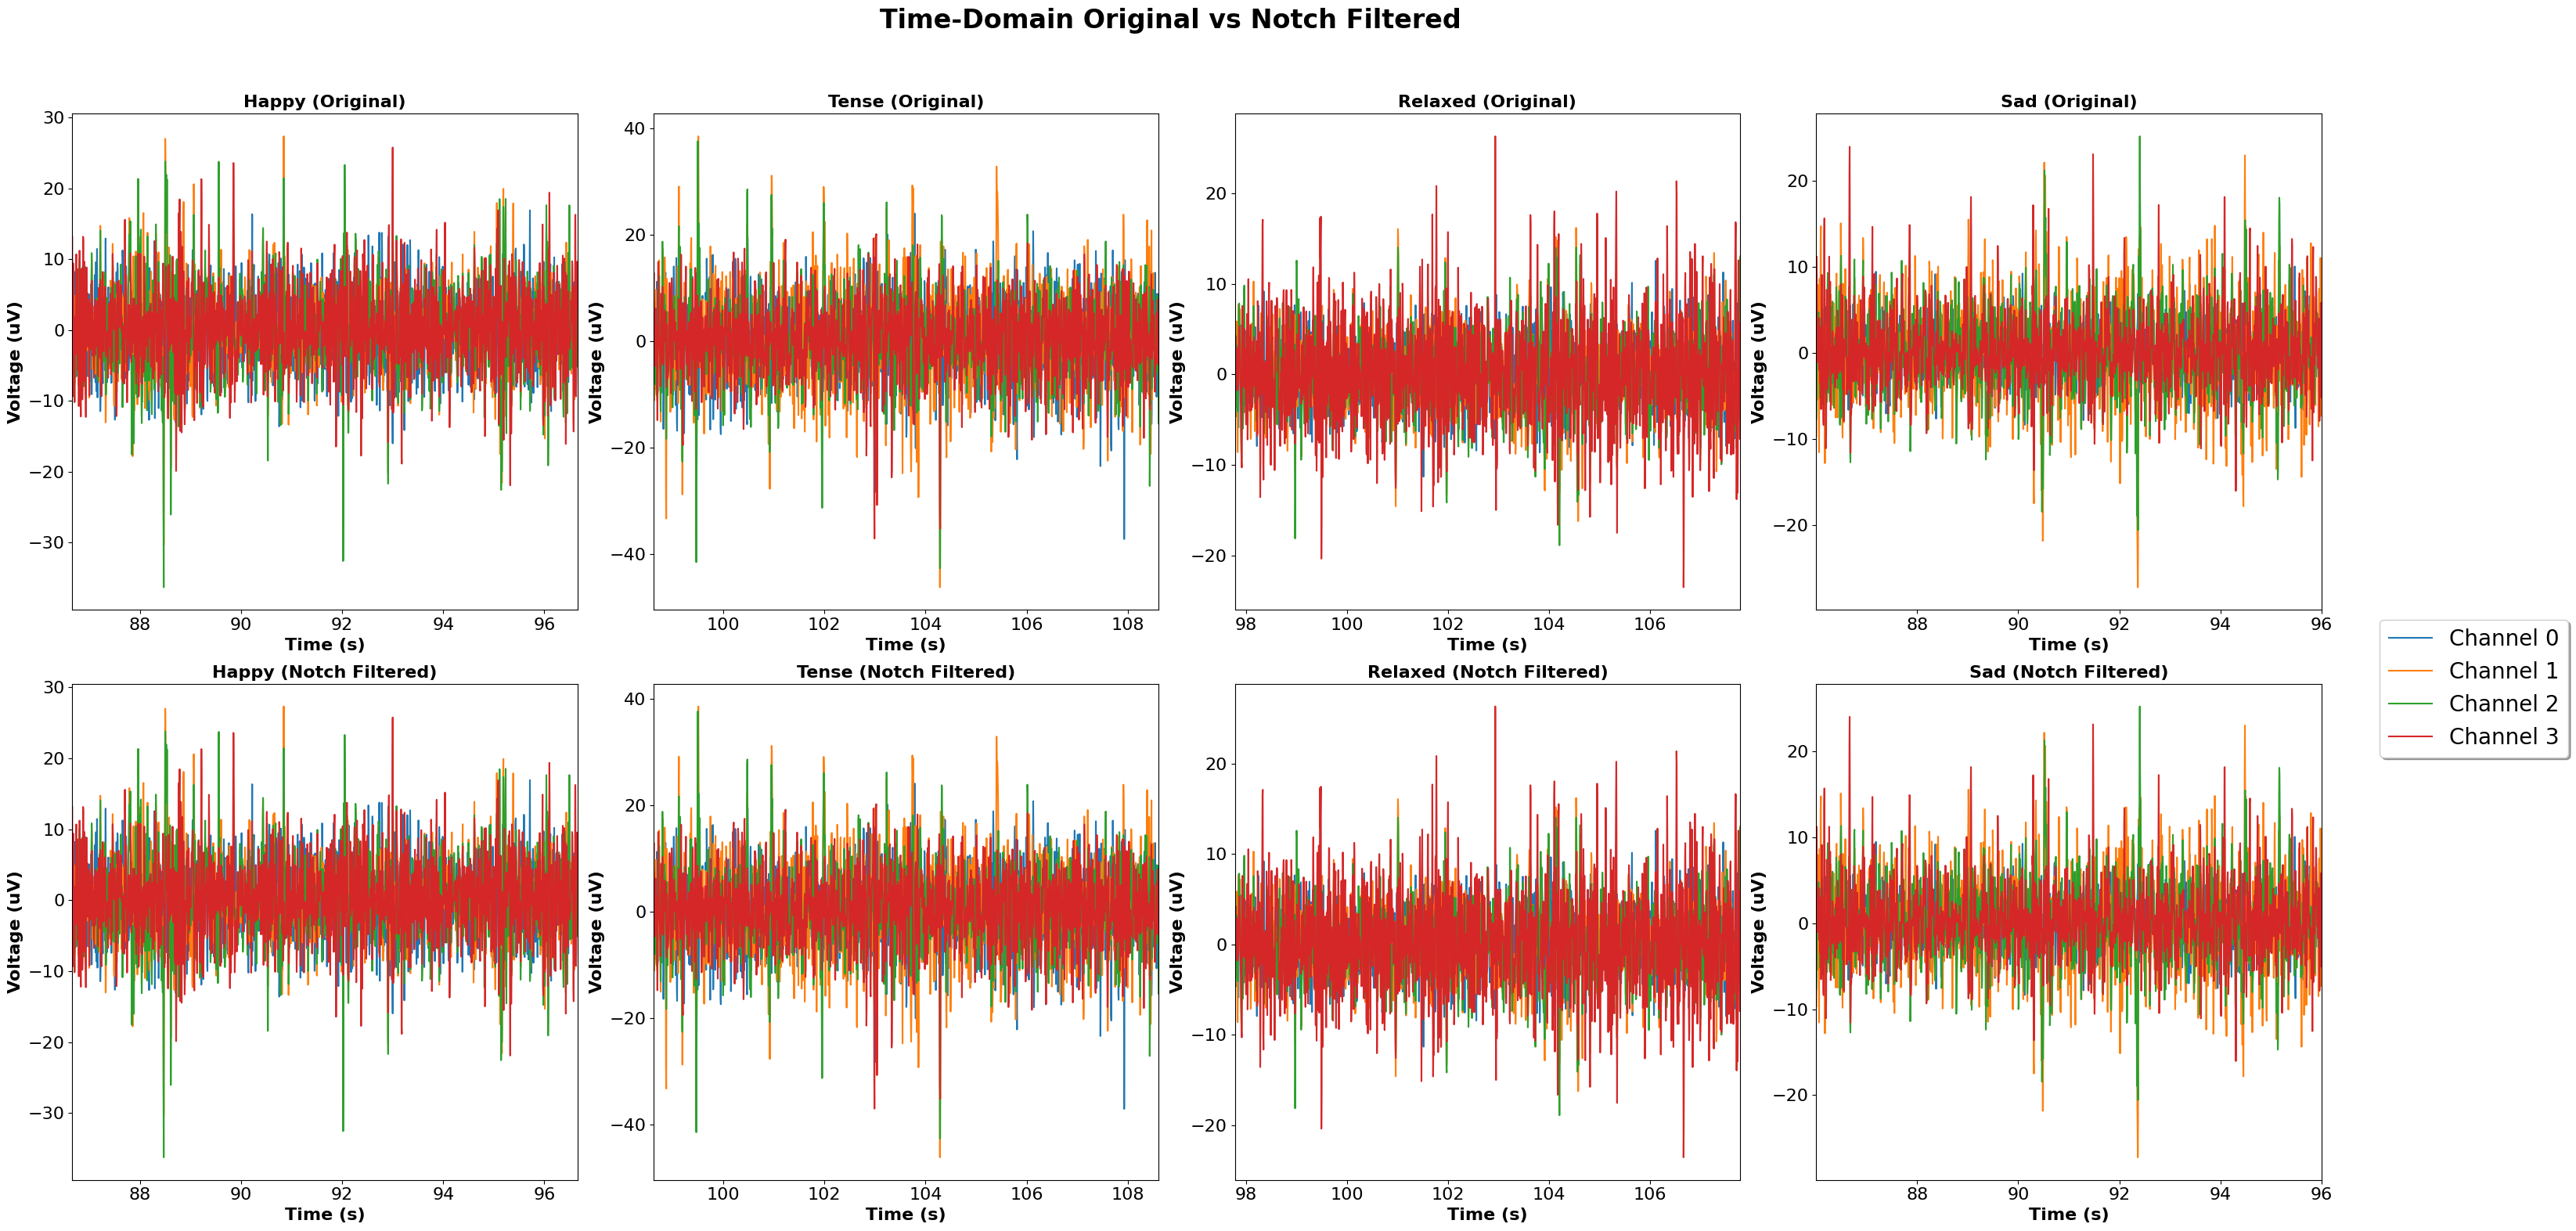

In [7]:
# # Time domain data with and without notch filter. I've applied a bandstop filter above so this will look differently!*************

def notch_filter(data, notch=60, quality_factor=100, fs=200):
    w0 = notch / (fs / 2) 
    b, a = signal.iirnotch(w0, quality_factor)
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

def plot_data_notch(data, fs, channels, power_ylim=None):

    n_states = len(data)
    freq_domain_data = {}  
    fig, axes = plt.subplots(2, n_states, figsize=(30, 16))
    fig.suptitle("Time-Domain Original vs Notch Filtered", fontsize=24, fontweight='bold')

    last_10_sec_samples = fs * 10

    # First pass: plot original data
    for col, (state, state_data) in enumerate(data.items()):
      
        t_vec = np.arange(state_data.shape[1] - last_10_sec_samples, state_data.shape[1]) / fs

        # Plot time-domain data
        for i, ch in enumerate(state_data):
            axes[0, col].plot(t_vec, ch[-2000:], label=f'Channel {channels[i]}' if col == 0 else None)
        axes[0, col].set_title(f'{state} (Original)', fontsize=16, fontweight='bold')
        axes[0, col].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
        axes[0, col].set_ylabel('Voltage (uV)', fontsize=16, fontweight='bold')
        axes[0, col].set_xlim([t_vec[0], t_vec[-1]])
        #axes[0, col].set_ylim([-25, 25])
        axes[0, col].tick_params(axis='both', which='major', labelsize=16)

    # Apply notch filter and plot filtered data
    filtered_data = {}  
    for state, state_data in data.items():
        filtered_data[state] = np.array([notch_filter(ch, notch=60, quality_factor=100, fs=fs) for ch in state_data])

    for col, (state, state_data) in enumerate(filtered_data.items()):
        # Create time vector for the last 10 seconds
        t_vec = np.arange(state_data.shape[1] - last_10_sec_samples, state_data.shape[1]) / fs

        # Plot time-domain data (filtered)
        for i, ch in enumerate(state_data):
            axes[1, col].plot(t_vec, ch[-2000:], label=f'Channel {channels[i]}' if col == 0 else None)
        axes[1, col].set_title(f'{state} (Notch Filtered)', fontsize=16, fontweight='bold')
        axes[1, col].set_xlabel('Time (s)', fontsize=16, fontweight='bold')
        axes[1, col].set_ylabel('Voltage (uV)', fontsize=16, fontweight='bold')
        axes[1, col].set_xlim([t_vec[0], t_vec[-1]])
        #axes[1, col].set_ylim([-25, 25])
        axes[1, col].tick_params(axis='both', which='major', labelsize=16)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 0.5), fontsize=20, shadow=True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return 

plot_data_notch(data=antonio_data, fs=fs, channels=channels)


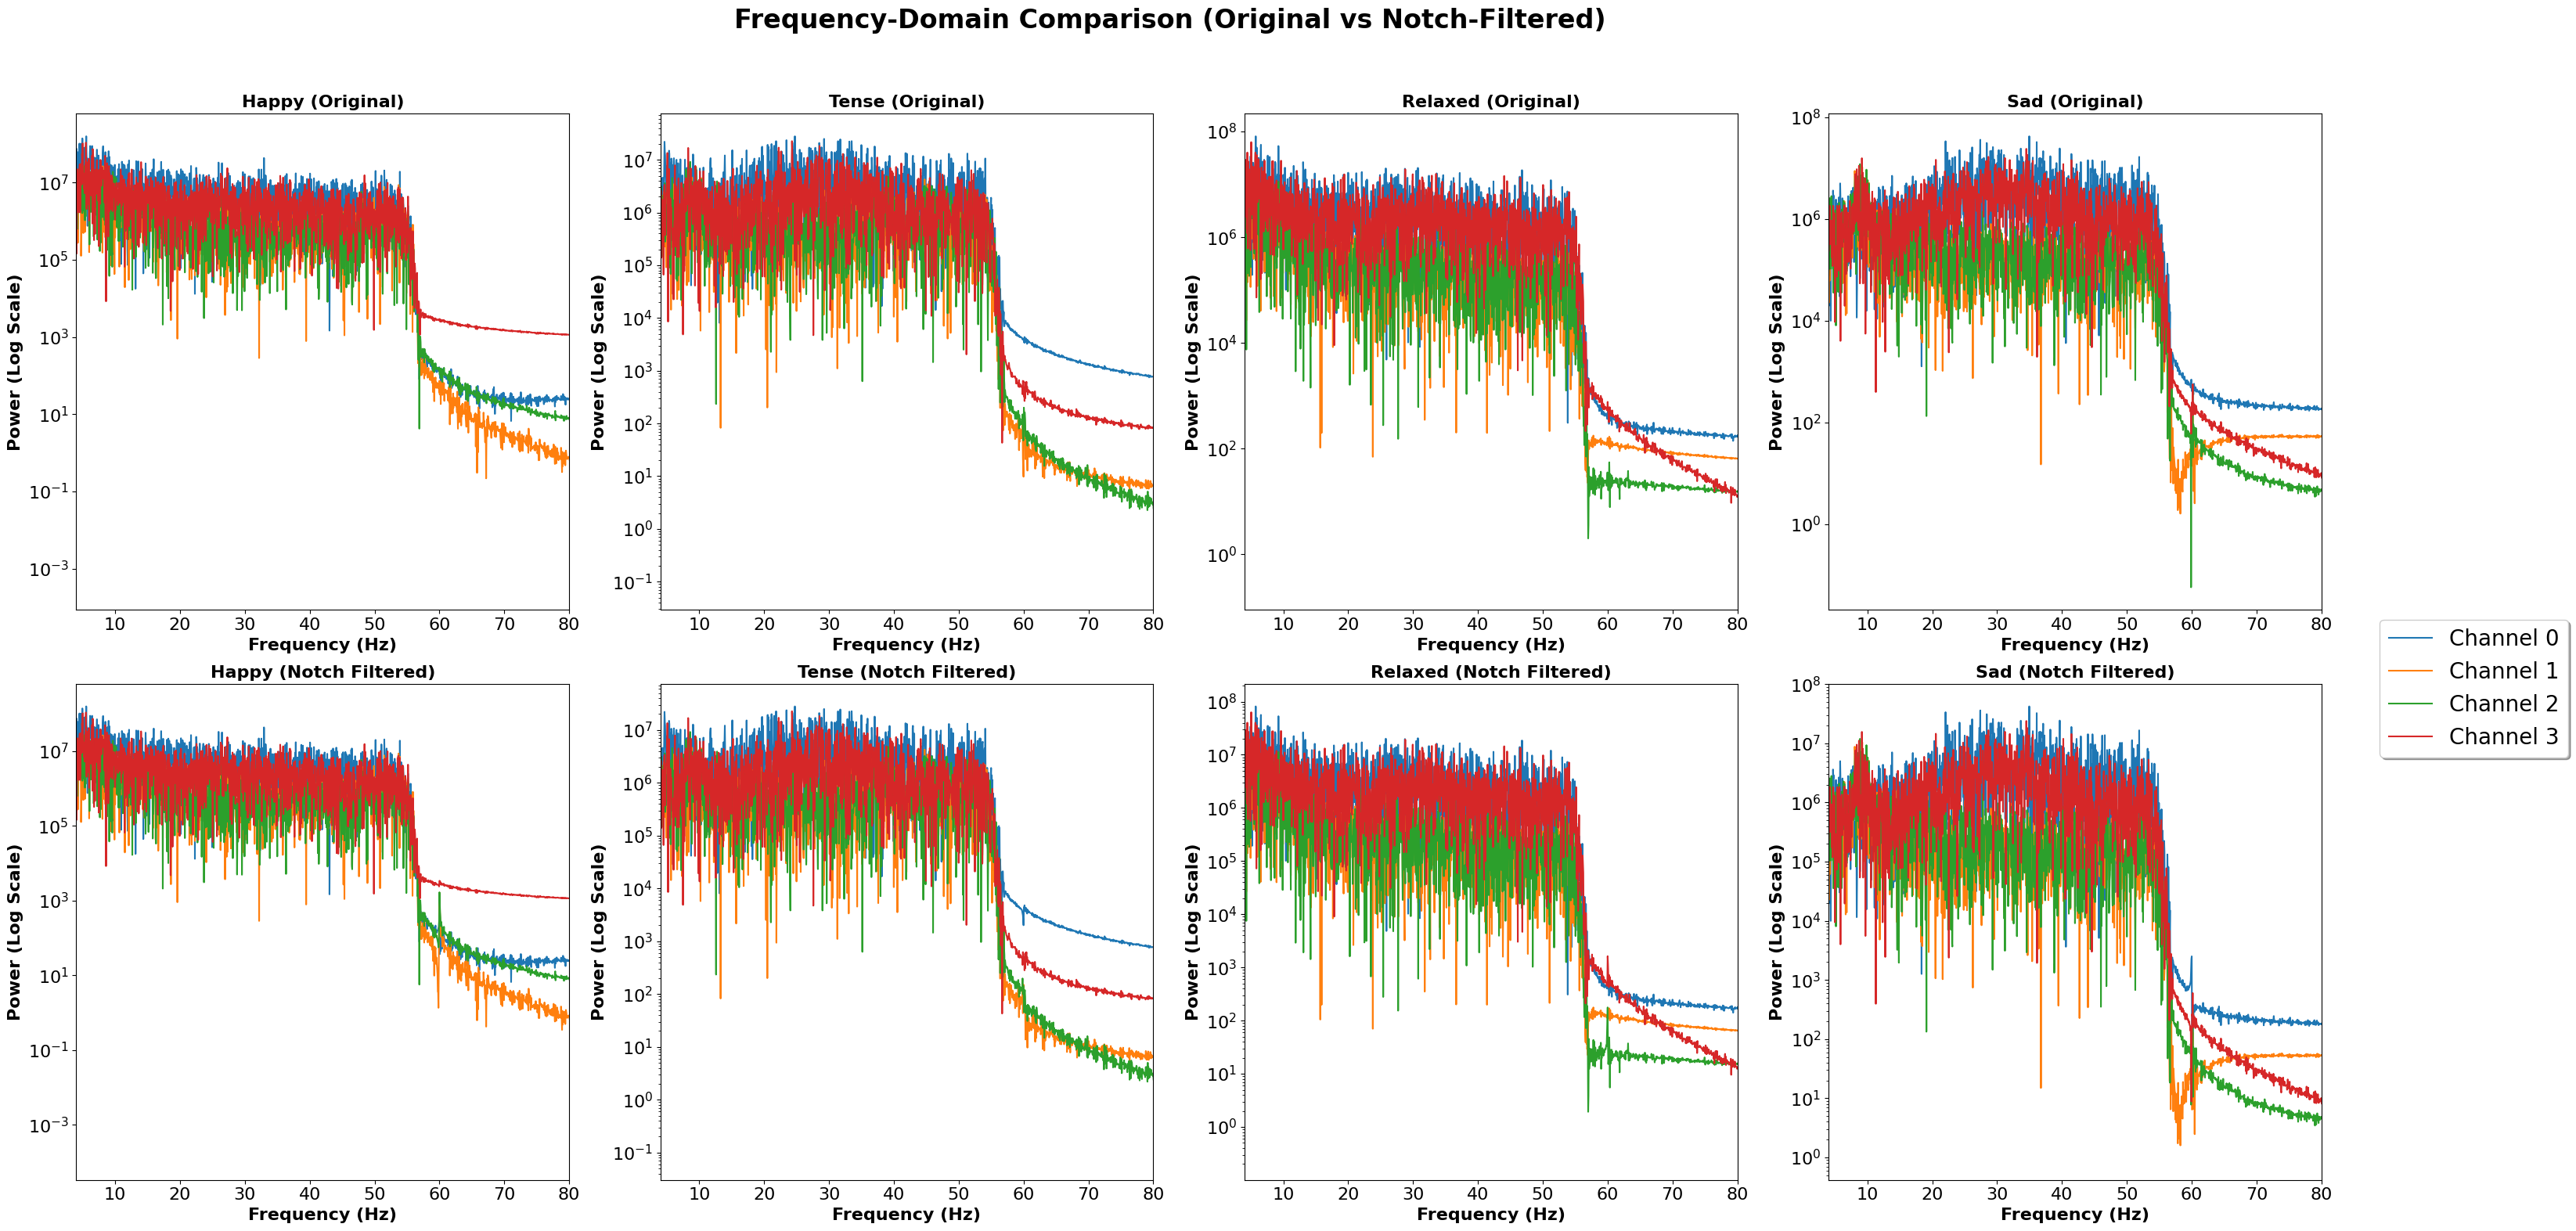

In [8]:
# # Frequency Domain Plots with and without notch filter. I've applied a bandstop filter above so this will look differently!*************

def notch_filter(data, notch=60, quality_factor=1000, fs=200):
    w0 = notch / (fs / 2) 
    b, a = signal.iirnotch(w0, quality_factor)
    return signal.filtfilt(b, a, data)

def plot_freq_data_notch(data, fs, channels, power_ylim=None):
    n_states = len(data)
    freq_domain_data = {}
    fig, axes = plt.subplots(2, n_states, figsize=(30, 16))
    fig.suptitle("Frequency-Domain Comparison (Original vs Notch-Filtered)", fontsize=24, fontweight='bold')

    last_10_sec_samples = fs * 20  

    for col, (state, state_data) in enumerate(data.items()):
        last_10_sec_data = state_data[:, -last_10_sec_samples:]  # Extract last 10 seconds of data
        freqs = rfftfreq(last_10_sec_samples, d=1 / fs)
        
        freq_domain_data[state] = {"frequencies": freqs, "power_spectra": []}

        for i, ch in enumerate(last_10_sec_data):
            ps = np.abs(rfft(ch))**2
            axes[0, col].plot(freqs, ps, label=f'Channel {channels[i]}' if col == 0 else None)
            freq_domain_data[state]["power_spectra"].append(ps)

        axes[0, col].set_title(f'{state} (Original)', fontsize=16, fontweight='bold')
        axes[0, col].set_xlabel('Frequency (Hz)', fontsize=16, fontweight='bold')
        axes[0, col].set_ylabel('Power (Log Scale)', fontsize=16, fontweight='bold')
        axes[0, col].set_xlim([4, 80])
        axes[0, col].set_yscale('log')
        if power_ylim:
            axes[0, col].set_ylim(power_ylim)
        axes[0, col].tick_params(axis='both', which='major', labelsize=16)

    filtered_data = {state: np.array([notch_filter(ch, notch=60, quality_factor=1000, fs=fs) 
                                      for ch in state_data]) for state, state_data in data.items()}

    for col, (state, state_data) in enumerate(filtered_data.items()):
        last_10_sec_data = state_data[:, -last_10_sec_samples:]  # Extract last 10 seconds of filtered data
        freqs = rfftfreq(last_10_sec_samples, d=1 / fs)

        for i, ch in enumerate(last_10_sec_data):
            ps = np.abs(rfft(ch))**2
            axes[1, col].plot(freqs, ps, label=f'Channel {channels[i]}' if col == 0 else None)

        axes[1, col].set_title(f'{state} (Notch Filtered)', fontsize=16, fontweight='bold')
        axes[1, col].set_xlabel('Frequency (Hz)', fontsize=16, fontweight='bold')
        axes[1, col].set_ylabel('Power (Log Scale)', fontsize=16, fontweight='bold')
        axes[1, col].set_xlim([4, 80])
        axes[1, col].set_yscale('log')
        if power_ylim:
            axes[1, col].set_ylim(power_ylim)
        axes[1, col].tick_params(axis='both', which='major', labelsize=16)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 0.5), fontsize=20, shadow=True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    return 

plot_freq_data_notch(luisa_data, fs, channels, power_ylim=None)


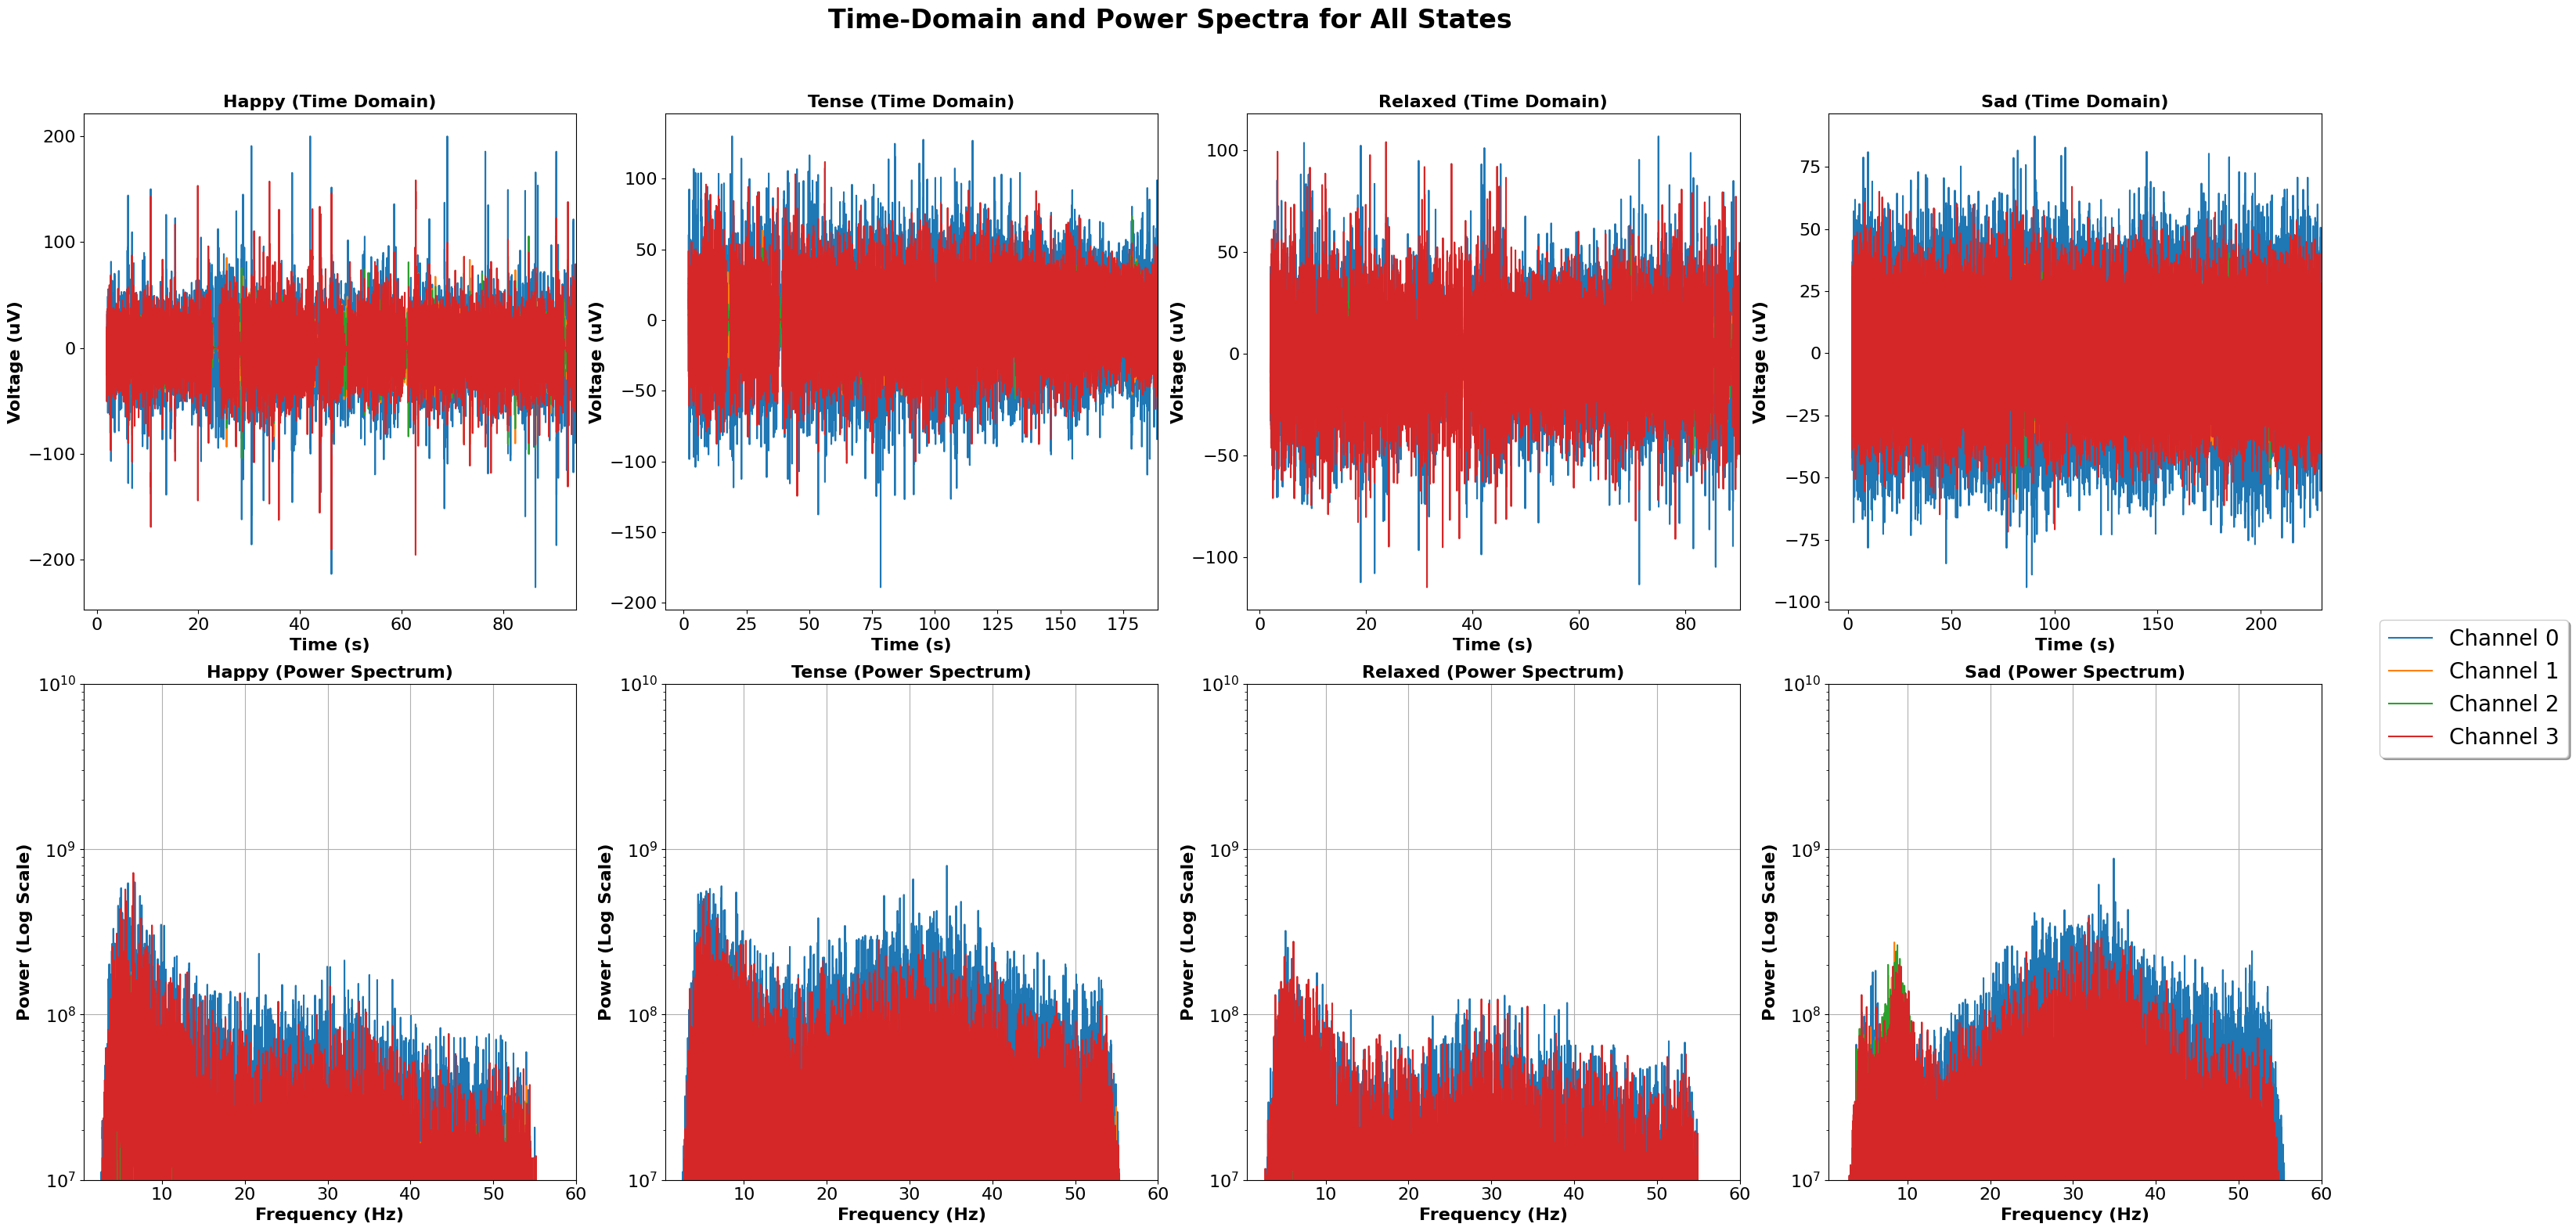

In [9]:
# # Plot luisa data
luisa_freq_data = plot_subject_data(data=luisa_data, fs=fs, channels=channels)

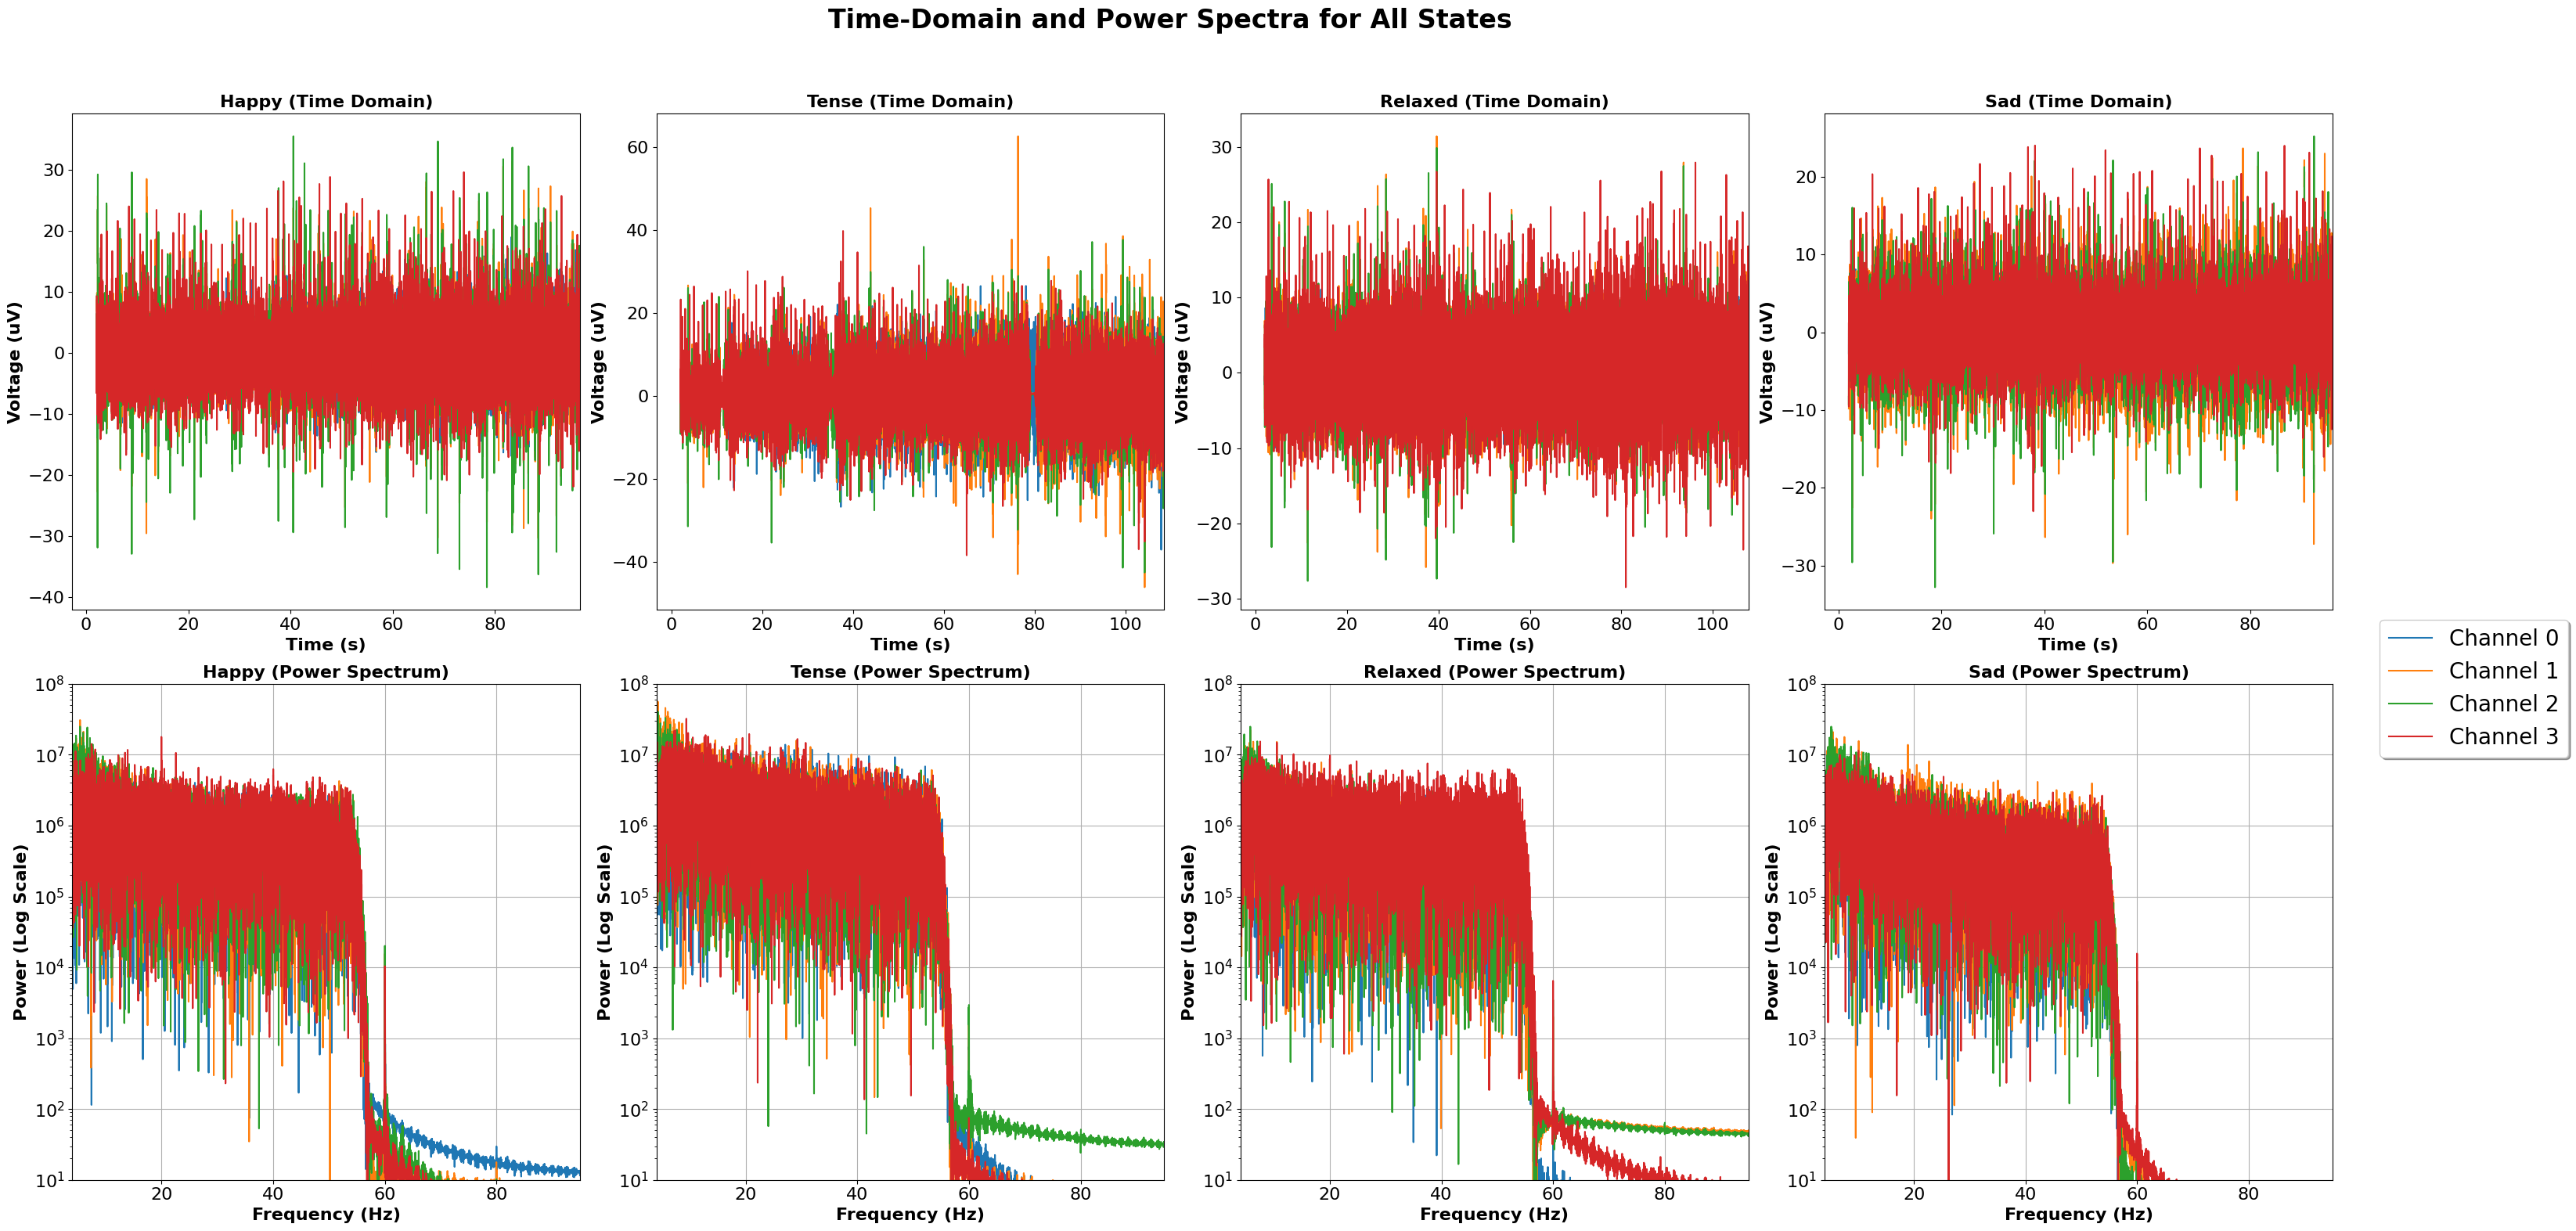

In [7]:
# # Plot antonio data
antonio_freq_data = plot_subject_data(data=antonio_data, fs=fs, channels=channels, power_ylim=[10,10**8 + 1000])

In [8]:
# # Create function to display STFT for each channel in each state

def plot_subject_stft(data,name,nperseg,vmax,fs=fs):

    n_states = len(data)   # for 2 channel plot set n_states = 2
    n_channels = len(next(iter(data.values())))

    fig,ax = plt.subplots(n_channels,n_states,figsize=(30,16)) # plt.subplots(4,2,figsize=(30,16))
    fig.suptitle(f"{name} Time-Frequency (STFT) Plot for All States and Channels", fontsize=24,fontweight='bold')

    # Calculate vmax for each state
    vmax_values = {state: max(np.max(signal.spectrogram(x=ch, nperseg=nperseg, noverlap=int(0.25 * nperseg), fs=fs)[2])
                              for ch in data) for state, data in data.items()}
    
    # Calculate vmax for entire dataset across all states
    vmax_all_states = np.max([value for _, value in vmax_values.items()])
    
    # Plot the STFT
    for row, (state, data) in enumerate(data.items()):
        for i,ch in enumerate(data):
            f_spg,t_spg,spg = signal.spectrogram(x=ch,nperseg=nperseg,noverlap=int(0.25*nperseg),fs=fs)

            cb = ax[i,row].pcolormesh(t_spg,f_spg,spg,shading='auto',cmap='viridis',vmin=0,vmax=vmax)
            ax[i,row].set(title=f'{state} - Channel {channels[i]}',xlabel='Time (s)',
                          ylabel='Frequency (Hz)',ylim=[4,55])
            
            if row == n_states - 1: 
                plt.colorbar(cb, ax=ax[i,row], label='Power')

            plt.tight_layout(rect=[0, 0, 1, 0.95]) 


    plt.show()


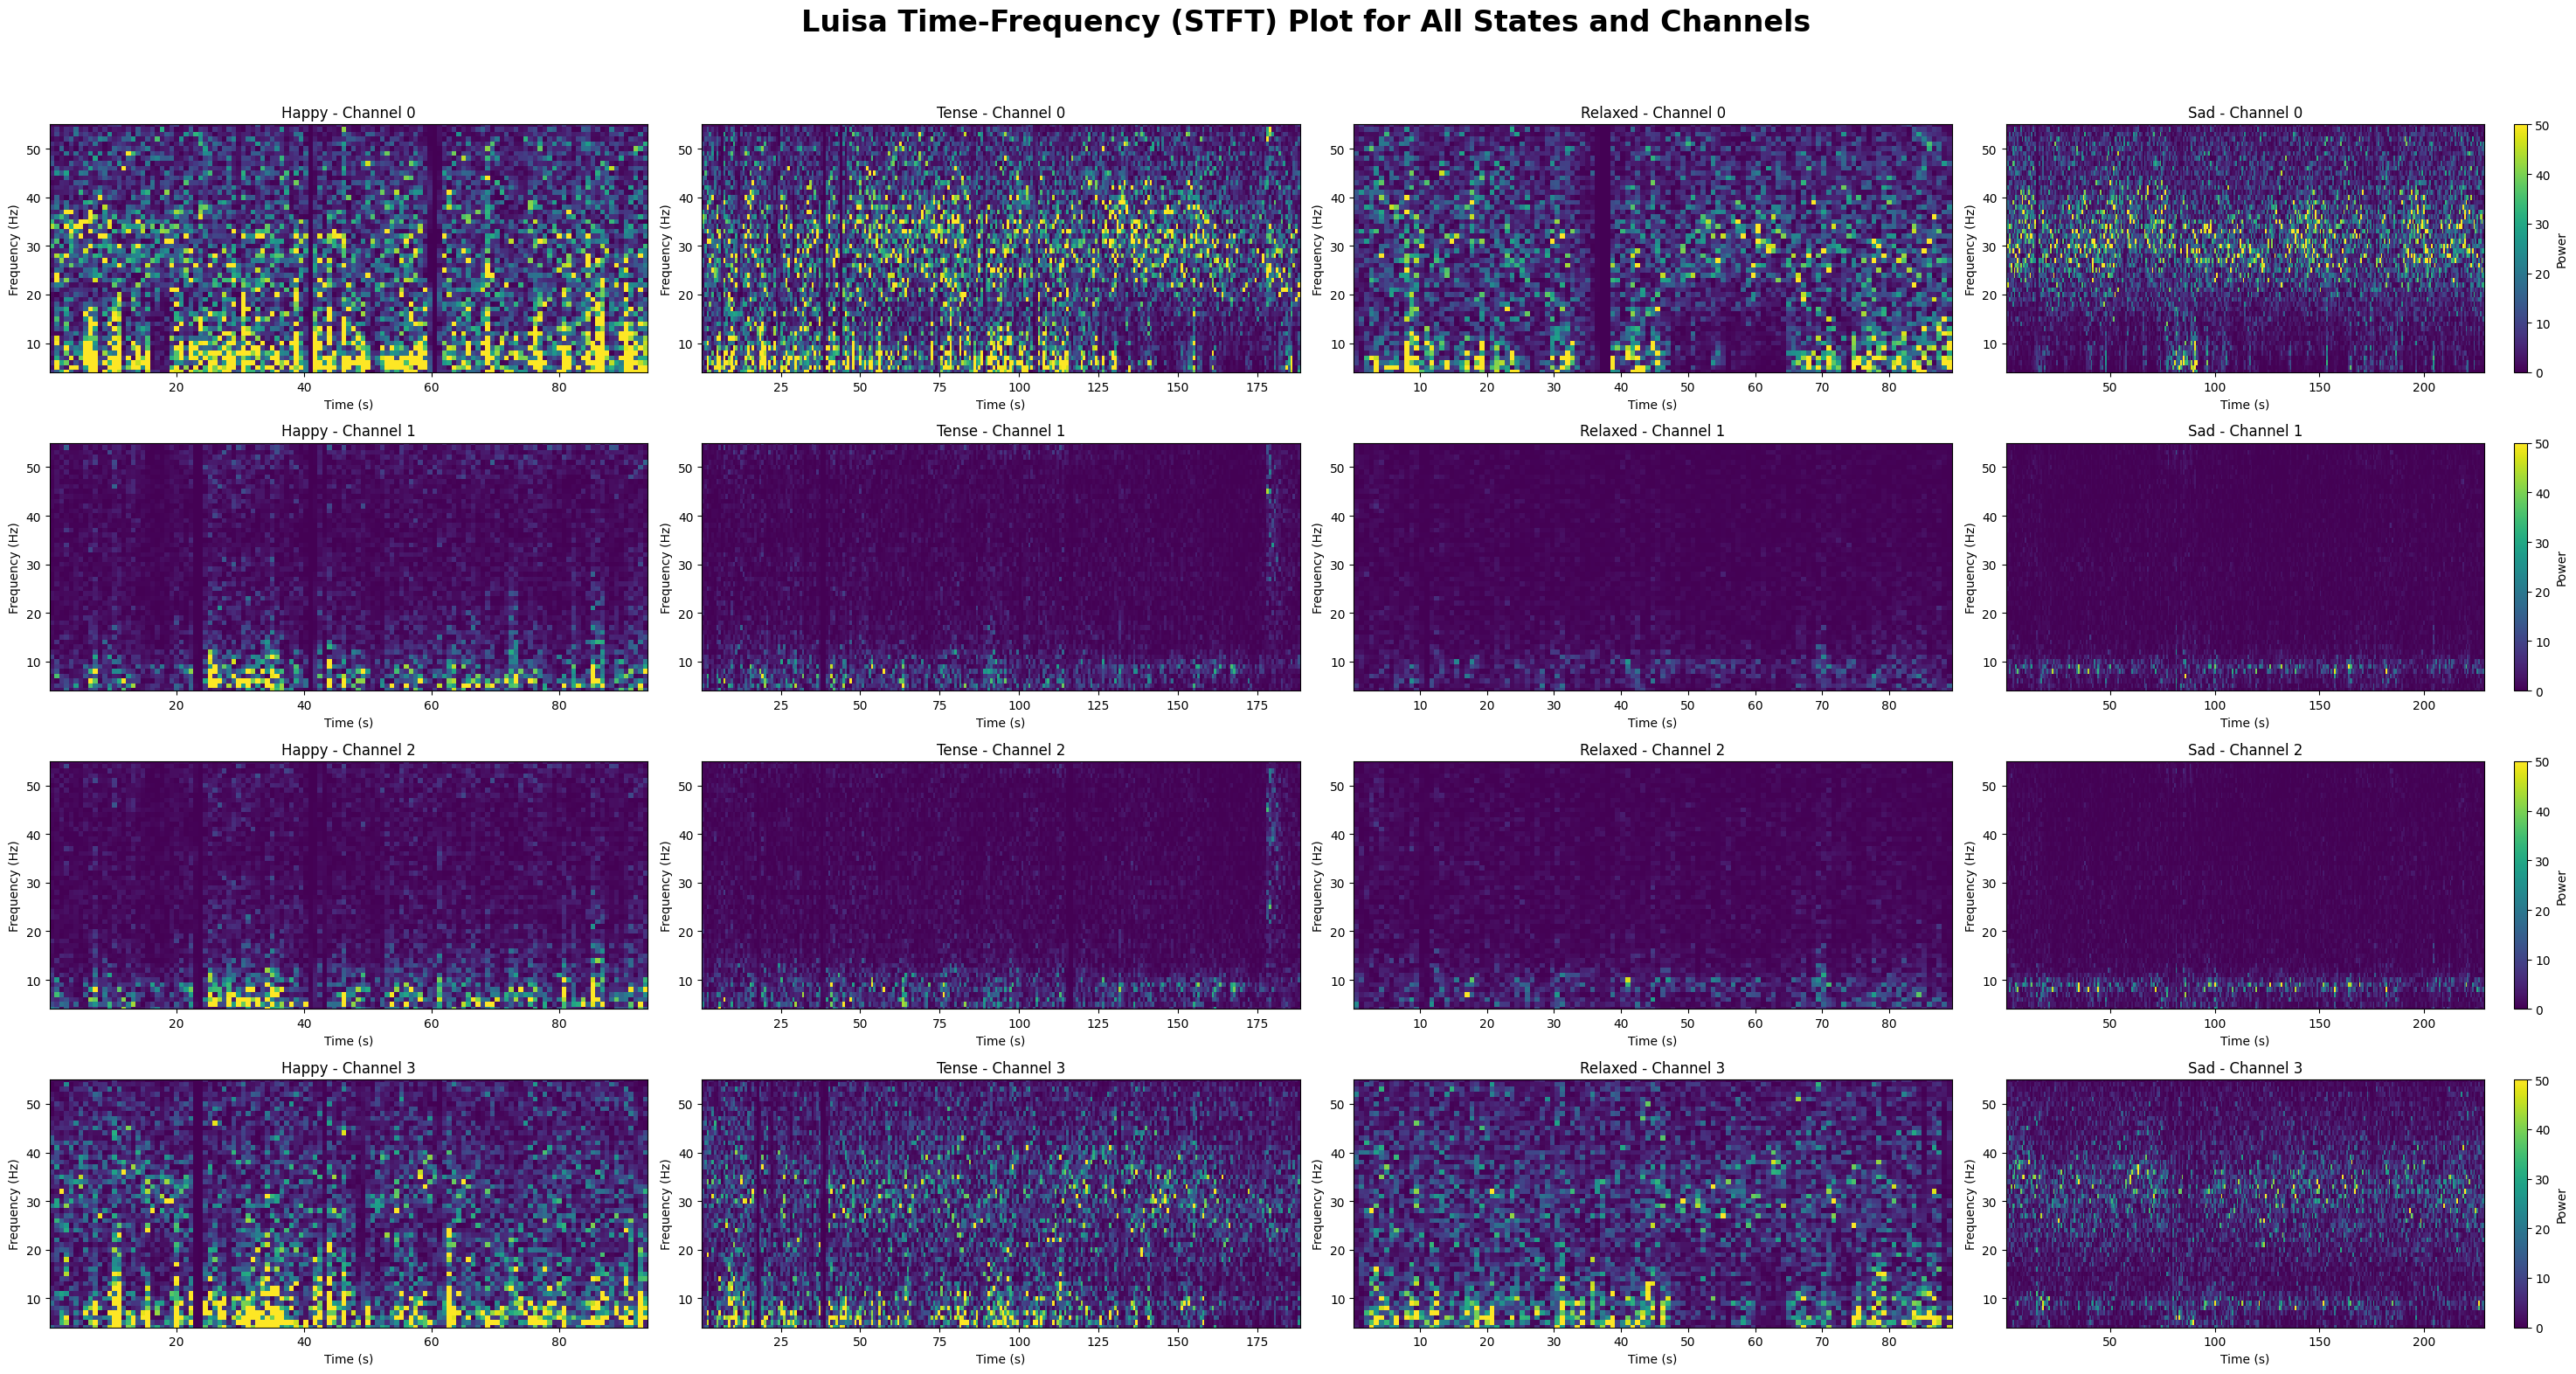

In [9]:
# # Plot STFT for Luisa Data

# WE FLIPPED THE DIAGRAM, now we have all states for one channel in each row

plot_subject_stft(luisa_data,name='Luisa',nperseg=int(fs), vmax=50)

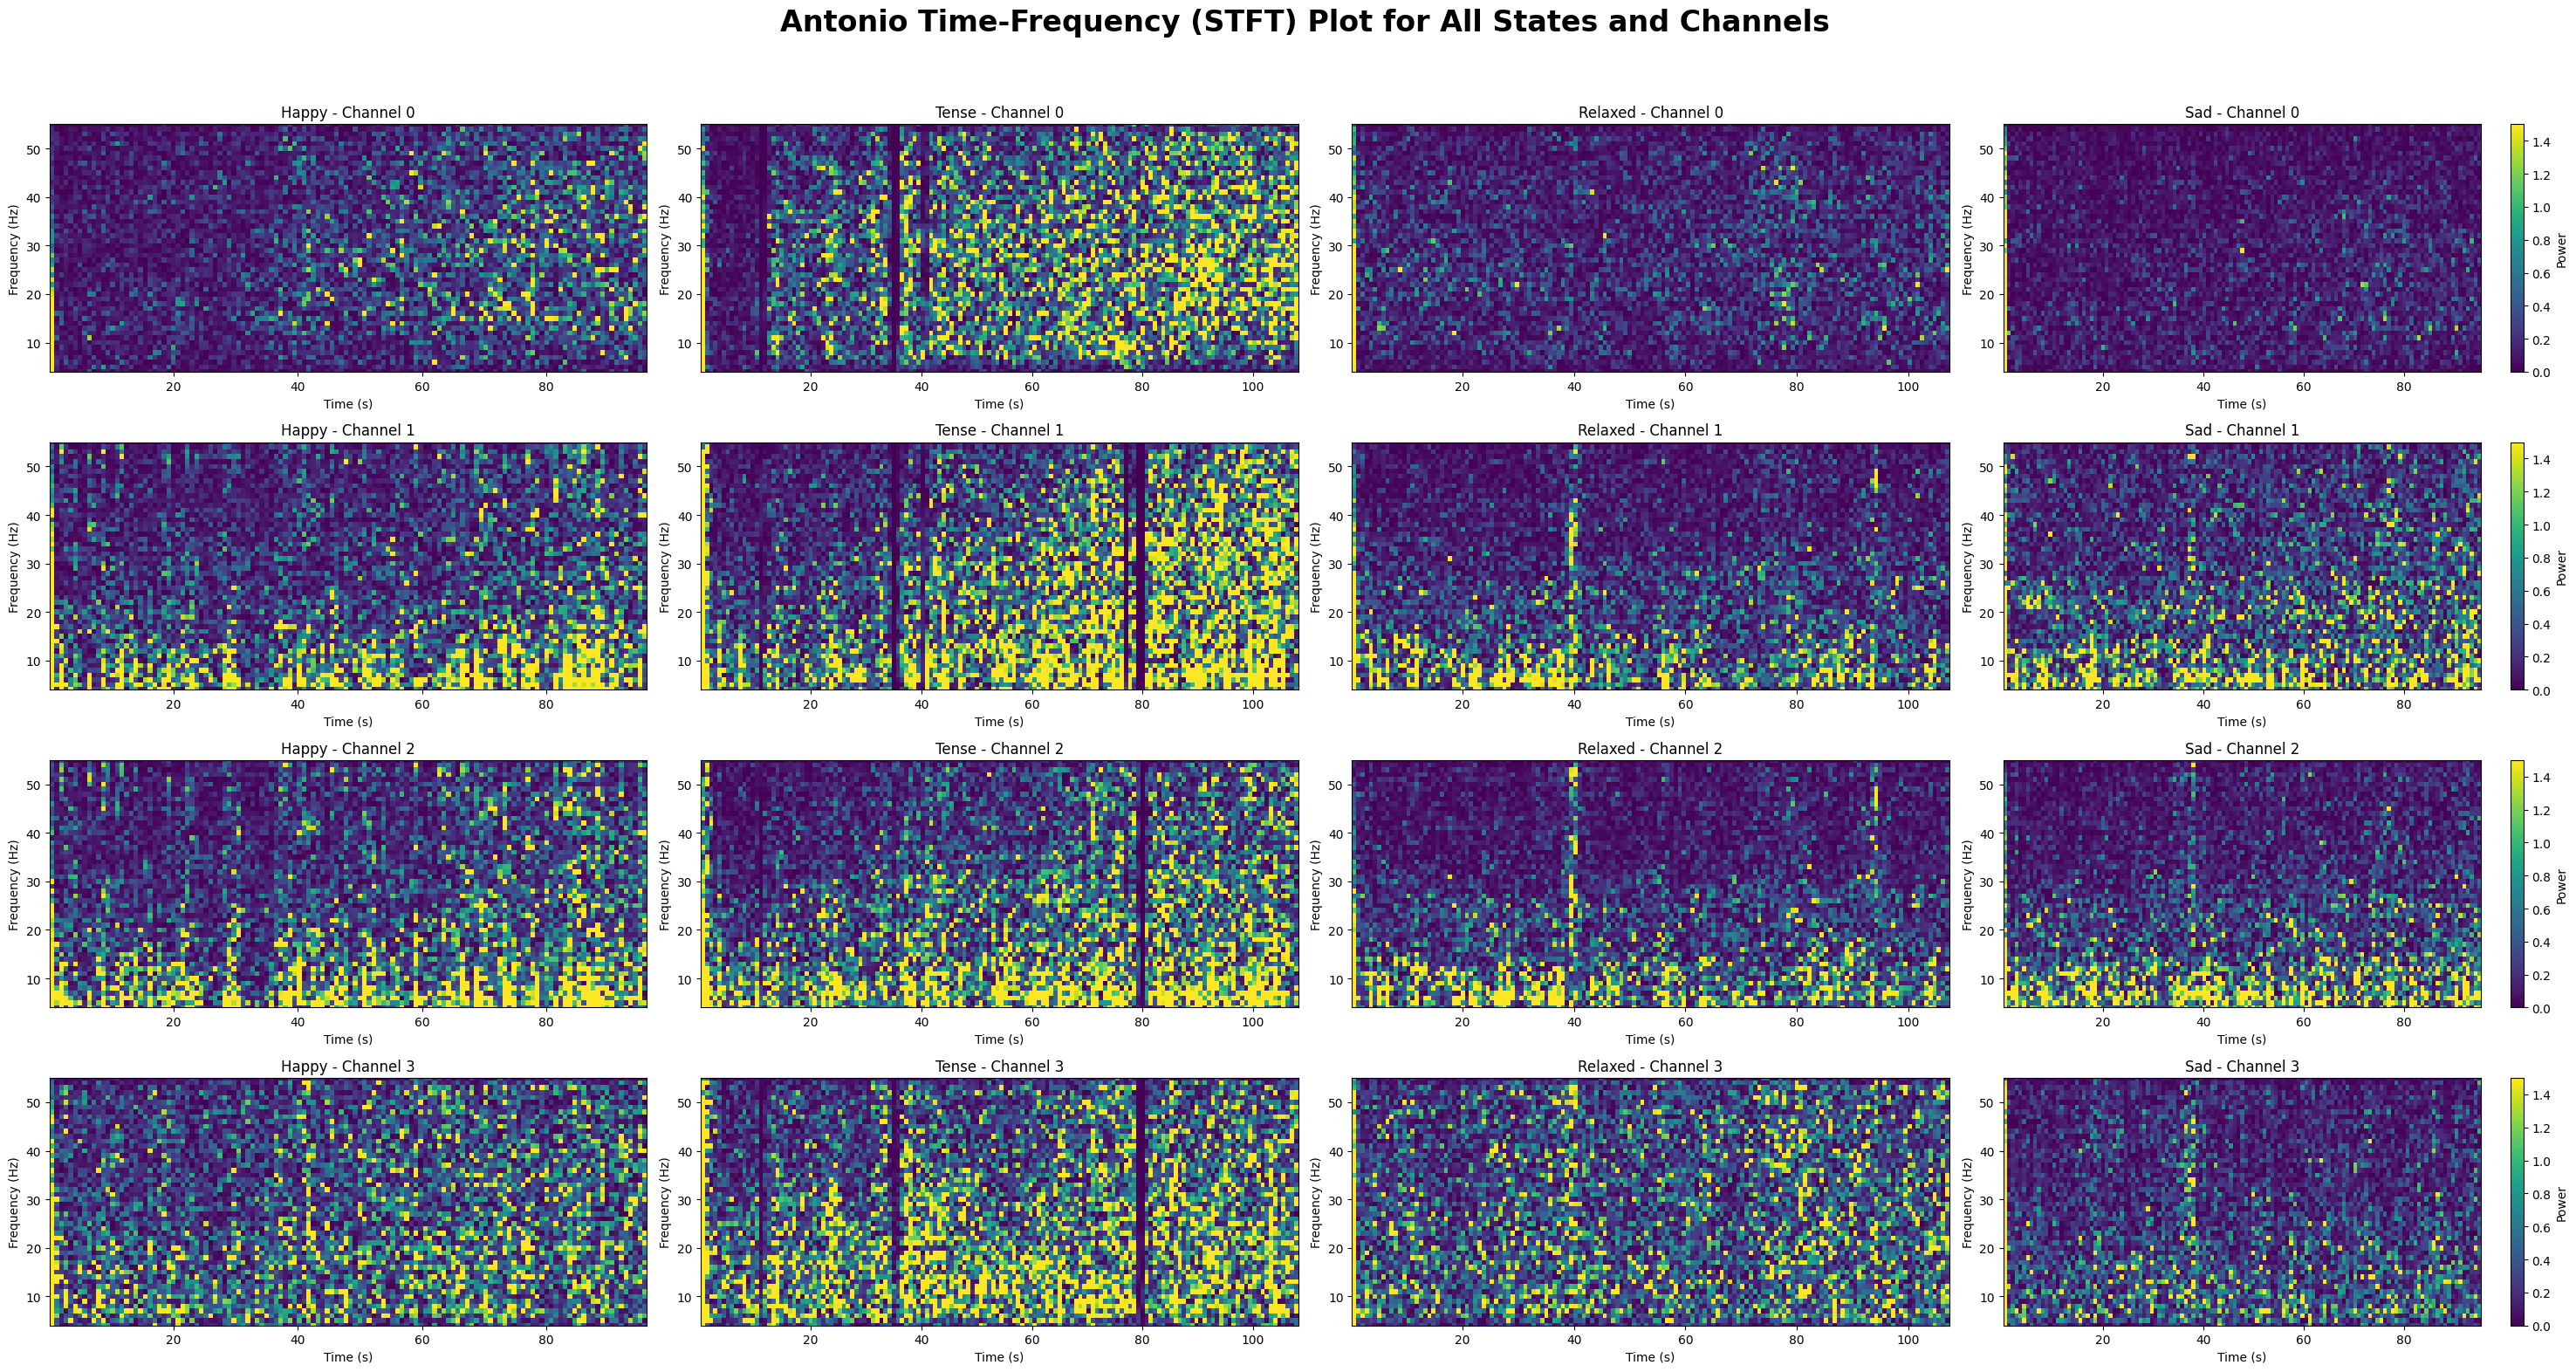

In [10]:
# # Plot STFT for Antonio Data 

plot_subject_stft(antonio_data,name='Antonio', nperseg=int(fs),vmax=1.5)


In [11]:
# # Grab the right mastoid region data only from Luisa and Antonio

luisa_data_rm = {state : luisa_data[state][0,:] for state in luisa_data.keys()}

antonio_data_rm = {state : antonio_data[state][0,:] for state in antonio_data.keys()}

print(luisa_data_rm['Sad'].shape)


(45879,)


In [12]:
# # Plot STFT of only Mastoid Region Channel

# # Create function to display STFT for each channel in each state

def plot_rmastoid_stft(data,name,nperseg,vmax,fs=fs):

    n_states = len(data)   
    n_channels = len(next(iter(data.values())))

    fig,ax = plt.subplots(1,4,figsize=(20,4))
    fig.suptitle(f"{name}'s Time-Frequency (STFT) Plot for Right Mastoid Channel", fontsize=10,fontweight='bold')


    # Plot the STFT for channel 0 - mastoid region
    for col, (state, ch) in enumerate(data.items()):
        f_spg,t_spg,spg = signal.spectrogram(x=ch,nperseg=nperseg,noverlap=int(0.25*nperseg),fs=fs)

        cb = ax[col].pcolormesh(t_spg,f_spg,spg, shading='auto',cmap='viridis',vmin=0,vmax=vmax)
        ax[col].set(title=f'{state}',xlabel='Time (s)',
                          ylabel='Frequency (Hz)',ylim=[4,55])
    
        if col == 3:
            plt.colorbar(cb, ax=ax[col], label='Power')
    
    plt.tight_layout()
    plt.show()


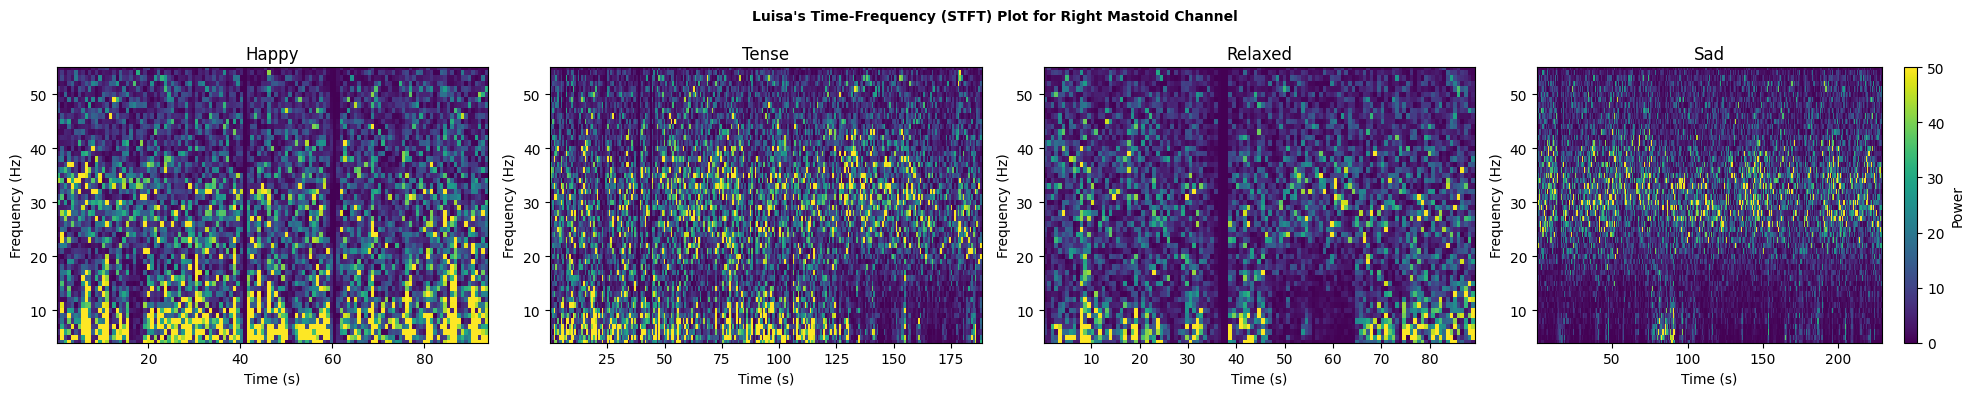

In [13]:
# Plot Luisa STFT Mastoid Channel

plot_rmastoid_stft(luisa_data_rm,name='Luisa',nperseg=int(fs),vmax=50)

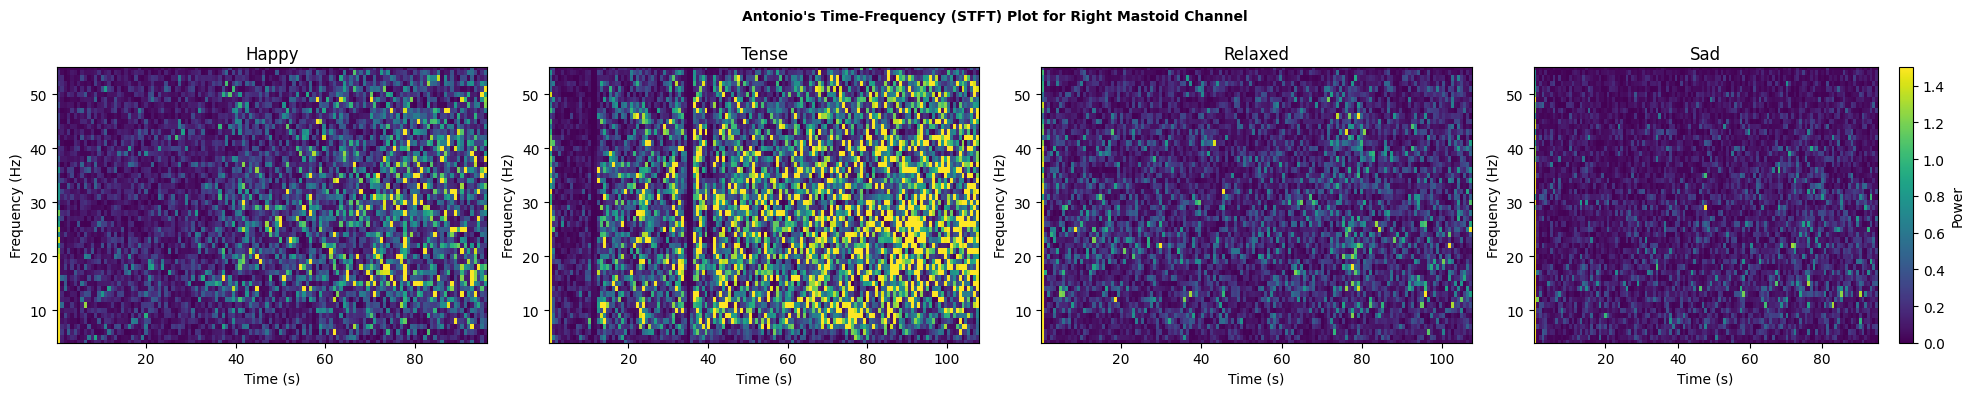

In [14]:
# Plot Antonio STFT Mastoid Channel

plot_rmastoid_stft(antonio_data_rm,name='Antonio',nperseg=int(fs),vmax=1.5)

In [ ]:
# # First calculate average power in frequency bands 

def calc_avg_band_power(data,nperseg, fs=fs):

    freq_ranges = {
    'theta':[4,8],
    'alpha1':[8,10],
    'alpha2':[10,12],
    'beta1':[12,18],
    'beta2':[18,24],
    'beta3':[24,30],
    'gamma1':[30,38],
    'gamma2':[38,46],
    'gamma3':[46,54]
    }

    state_data = {'Happy':[],
              'Tense':[],
              'Relaxed':[],
              'Sad':[]}
    
    subject_state_avg_power = {state: {} for state in state_data.keys()}

    # Loop through each state 
    for state, _ in subject_state_avg_power.items():
       
       # Obtain the PSD values for right mastoid channel in each state
       f_psd, psd = signal.welch(x=data[state],nperseg=nperseg,noverlap=int(nperseg*0.25),fs=fs)

       # Loop through frequency band ranges and obtain mean power for each band in the current state
       for band, (f_min, f_max) in freq_ranges.items():     
            band_mask = np.logical_and(f_psd >= f_min, f_psd <= f_max)
            subject_state_avg_power[state][band] = psd[band_mask].mean()  


    return subject_state_avg_power



In [16]:
# # Apply avg band power function to Luisa data

luisa_avg_band_power = calc_avg_band_power(luisa_data_rm,nperseg=int(fs))

luisa_avg_band_power['Happy']['alpha1']

33.396466163232155

In [17]:
# # Create function to plot the results from mean power band

def plot_avg_power(subject_state_avg_power,name):
    df = pd.DataFrame(subject_state_avg_power).T 
    df.plot(kind='bar', figsize=(10, 5), width=0.8, colormap='jet')
    plt.title(f"{name}'s Average Power Across Frequency Bands for Each State Bar Plot - Right Mastoid")
    plt.xlabel("Frequency Bands")
    plt.ylabel("Average Power")
    plt.xticks(rotation=45)
    plt.legend(title="States")
    plt.tight_layout()
    plt.show()

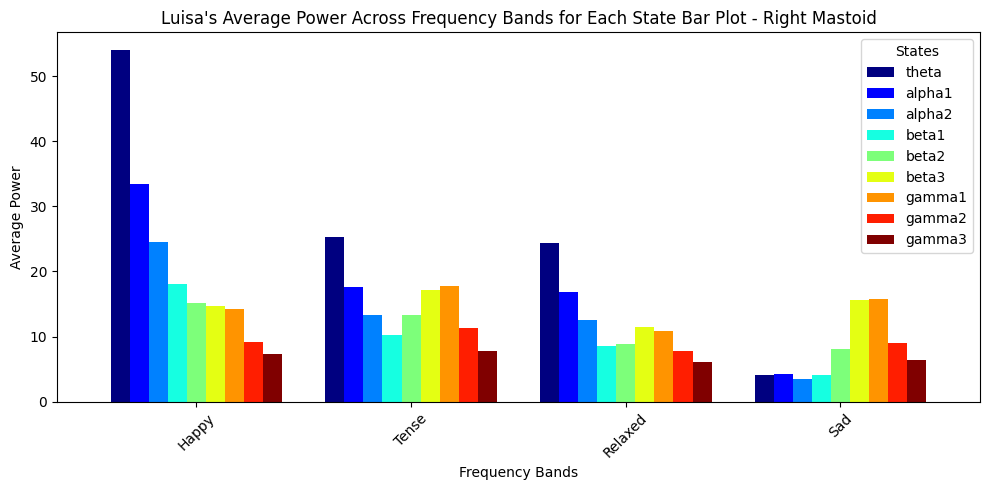

In [18]:
# # Plot Luisa Avg Power Bar Plot

plot_avg_power(luisa_avg_band_power,name='Luisa')

In [19]:
# # Create function for heatmap

def plot_avg_power_heatmap(subject_state_avg_power, name):
    df = pd.DataFrame(subject_state_avg_power).T 
    plt.figure(figsize=(9, 5))
    sns.heatmap(df, annot=True, cmap="viridis", fmt=".2f")
    plt.title(f"{name}'s Average Power Across Frequency Bands and States Heatmap - Right Mastoid")
    plt.xlabel("Frequency Bands")
    plt.ylabel("States")
    plt.tight_layout()
    plt.show()


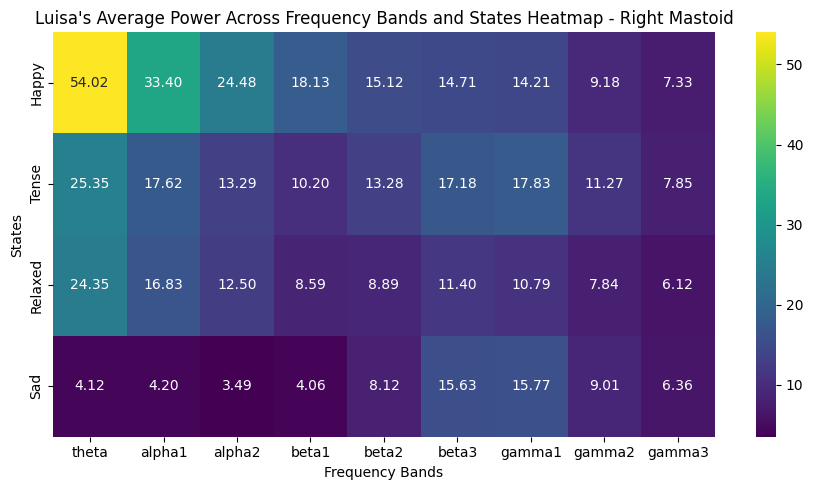

In [20]:
# # Plot Luisa Avg Power Heatmap

plot_avg_power_heatmap(luisa_avg_band_power, name='Luisa')

In [21]:
def plot_arousal_valence(subject_state_avg_power,name):
    # Group states by arousal and valence
    arousal_groups = {
        'High Arousal': ['Happy', 'Tense'],
        'Low Arousal': ['Relaxed', 'Sad']
    }
    valence_groups = {
        'High Valence': ['Happy', 'Relaxed'],
        'Low Valence': ['Tense', 'Sad']
    }

    # Calculate average power for each group
    arousal_avg = {group: {} for group in arousal_groups}
    valence_avg = {group: {} for group in valence_groups}

    for group, states in arousal_groups.items():
        for band in subject_state_avg_power['Happy']:
            arousal_avg[group][band] = np.mean([subject_state_avg_power[state][band] for state in states])

    for group, states in valence_groups.items():
        for band in subject_state_avg_power['Happy']:
            valence_avg[group][band] = np.mean([subject_state_avg_power[state][band] for state in states])

    # Plot High vs Low Arousal
    fig, ax = plt.subplots(figsize=(10,5))
    bands = list(subject_state_avg_power['Happy'].keys())
    ax.bar(bands, arousal_avg['High Arousal'].values(), color='blue', alpha=0.8, label='High Arousal')
    ax.bar(bands, arousal_avg['Low Arousal'].values(), color='orange', alpha=0.8, label='Low Arousal')
    ax.set_title(f"{name}'s Average Power by Arousal Levels")
    ax.set_xlabel("Frequency Bands")
    ax.set_ylabel("Average Power")
    ax.set_xticks(range(len(bands)))
    ax.set_xticklabels(bands, rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Plot High vs Low Valence
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(bands, valence_avg['High Valence'].values(), color='green', alpha=0.8, label='High Valence')
    ax.bar(bands, valence_avg['Low Valence'].values(), color='red', alpha=0.8, label='Low Valence')
    ax.set_title(f"{name}'s Average Power by Valence Levels")
    ax.set_xlabel("Frequency Bands")
    ax.set_ylabel("Average Power")
    ax.set_xticks(range(len(bands)))
    ax.set_xticklabels(bands, rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.show()

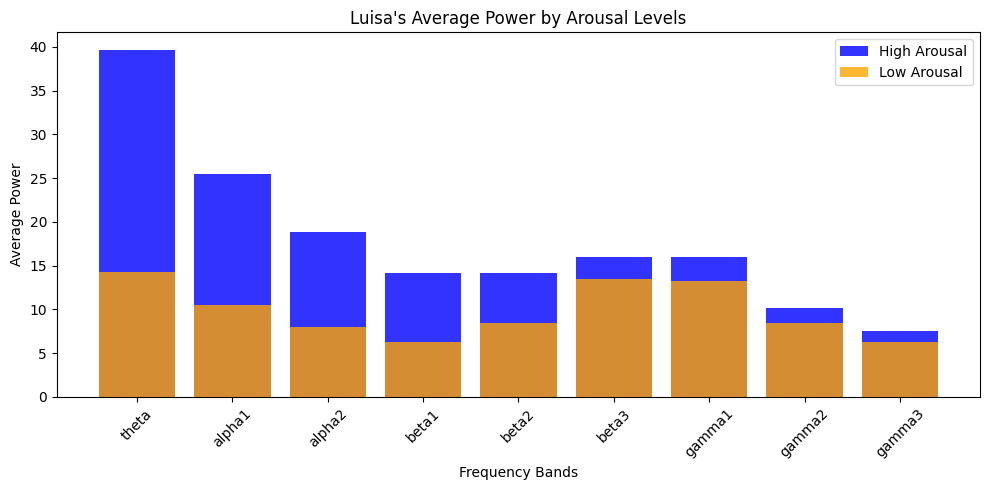

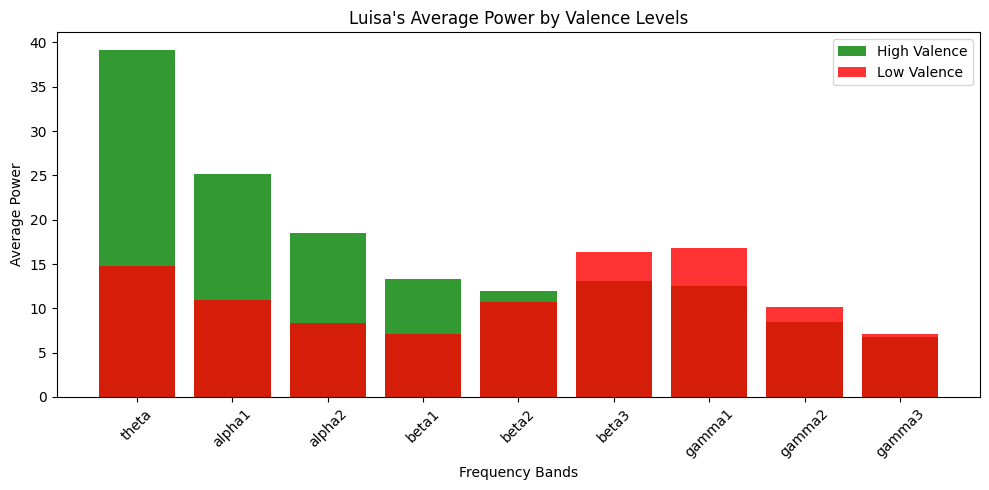

In [22]:
# # Plot Luisa Arousal and Valence Grouped Data

plot_arousal_valence(luisa_avg_band_power,name='Luisa')

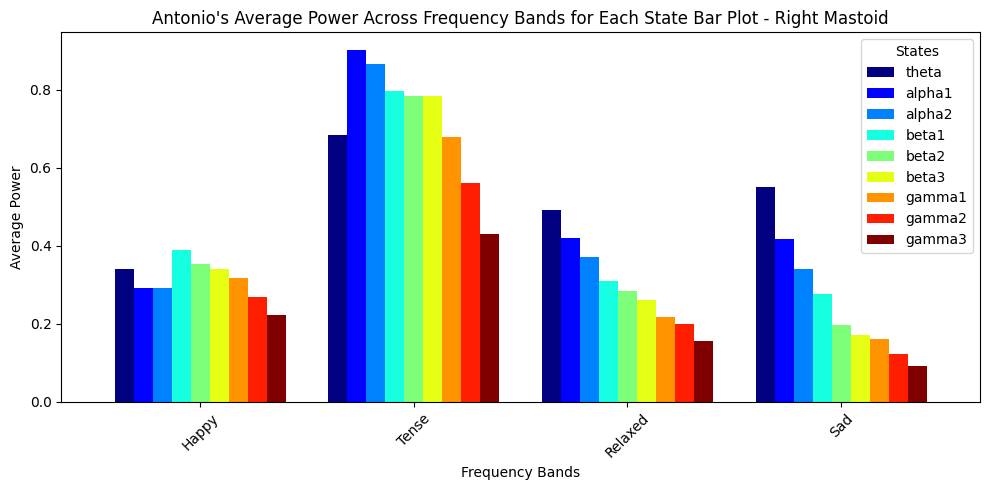

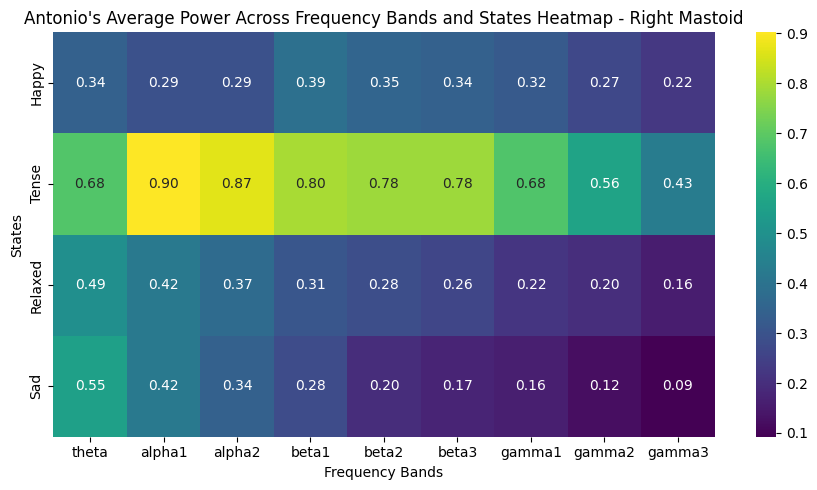

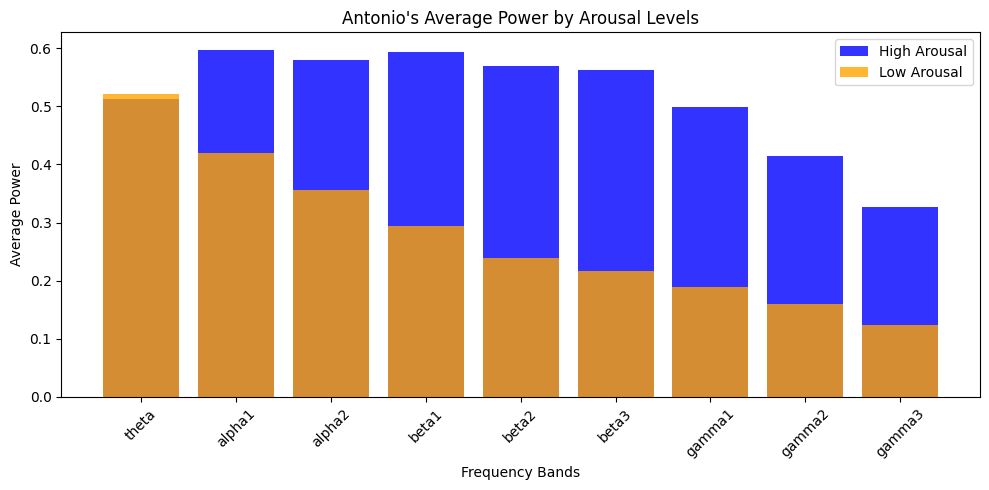

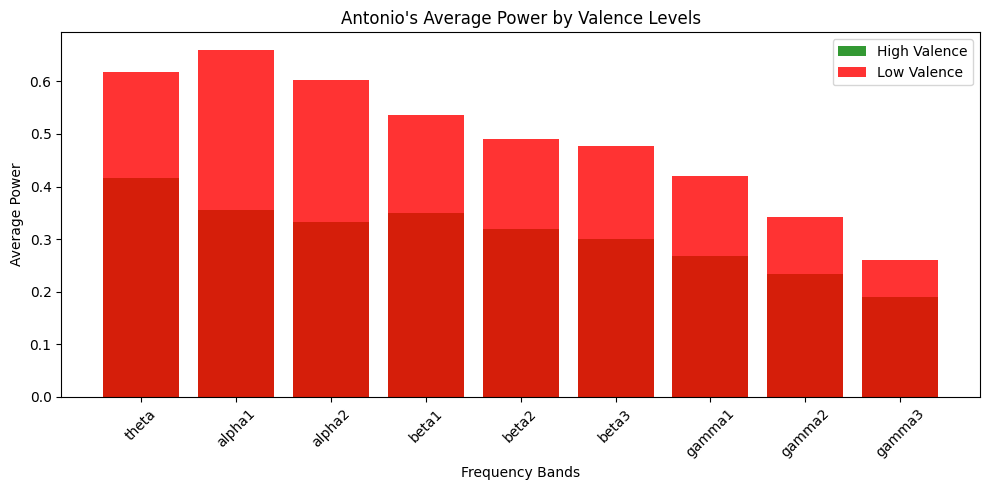

In [23]:
# # Plot avg band power metrics for Antonio data

antonio_avg_band_power = calc_avg_band_power(antonio_data_rm,nperseg=int(fs))
plot_avg_power(antonio_avg_band_power,name='Antonio')
plot_avg_power_heatmap(antonio_avg_band_power,name='Antonio')
plot_arousal_valence(antonio_avg_band_power,name='Antonio')


In [24]:
# # Create function for all temporal variability metrics 

def calc_temporal_metrics(data,nperseg,fs=fs):
    
    freq_ranges = {
    'theta': [4, 8],
    'alpha1': [8, 10],
    'alpha2': [10, 12],
    'beta1': [12, 18],
    'beta2': [18, 24],
    'beta3': [24, 30],
    'gamma1': [30, 38],
    'gamma2': [38, 46],
    'gamma3': [46, 54]
}
    
    metrics = {state: {} for state in data.keys()}
    
    for state, channel in data.items():
        f, t, spg = signal.spectrogram(channel, fs=fs, nperseg=nperseg, noverlap=int(fs*0.25))
        
        for band, (f_min, f_max) in freq_ranges.items():
            band_mask = np.logical_and(f >= f_min, f <= f_max)
            band_power = spg[band_mask].mean(axis=0)
            
            # Calculate metrics
            metrics[state][band] = {
                'std dev': np.std(band_power),                     # Standard deviation
                'range': np.max(band_power) - np.min(band_power),  # Range
                'cv': (np.std(band_power) / np.mean(band_power)) * 100,  # Coefficient of Variation
                'skewness': stats.skew(band_power),                     # Skewness
                'kurtosis': stats.kurtosis(band_power),                 # Kurtosis
                'mad': np.median(np.abs(band_power - np.median(band_power)))  # Median Absolute Deviation
            }
    

    '''

    Notes:
    -These are all temporal metrics grouped together under the broader category of temporal variability, with the first metric (SDV) being
    the primary measure of variability. The additional metrics are complementary and and help to explore different aspects of variability
    in the data. 

    -Standard deviation of the 1D array containing avg power of a band along time axis measures average fluctuations/variance of that frequency
    over time. We can see how variable/how much fluctuation there is for each frequency band. We would expect high arousal to have greater
    fluctuation/variability because of hypsersenstivity to emotions(heightened neural activity) and low arousal to have less variability due to
    being in a calmer state.

    Range: Focuses on extreme differences (peak to peak variability).

    Coefficient of Variation: Normalizes variability relative to the mean, allowing comparisons across frequency bands or states.

    Skewness: Adds information about the direction of variability (like transient bursts vs. baseline activity).

    Kurtosis: Highlights whether variability is caused by extreme outliers or steady fluctuations.
    
    Median Absolute Deviation: A robust non-parametric variability measure that's less sensitive to outliers than standard deviation.

    '''



    return metrics


In [25]:
# # Create function to plot the additional temporal variability metrics

# def plot_temporal_metrics(metrics, metric_name):
#     states = list(metrics.keys())
#     bands = list(next(iter(metrics.values())).keys())
#     metric_matrix = np.array([[metrics[state][band][metric_name] for band in bands] for state in states])

#     fig, ax = plt.subplots(figsize=(10,5))
#     x = np.arange(len(bands))
#     width = 0.2

#     for i, state in enumerate(states):
#         ax.bar(x + i * width, metric_matrix[i], width, label=state)

#     ax.set_xticks(x + width * (len(states) - 1) / 2)
#     ax.set_xticklabels(bands, rotation=45)
#     ax.set_title(f"Temporal {metric_name.capitalize()} Across Frequency Bands and States")
#     ax.set_xlabel("Frequency Bands")
#     ax.set_ylabel(metric_name.capitalize())
#     ax.legend()
#     plt.tight_layout()
#     plt.show()


def plot_temporal_metrics(metrics,name):
    states = list(metrics.keys())
    bands = list(next(iter(metrics.values())).keys())
    metric_names = list(next(iter(next(iter(metrics.values())).values())).keys())

    for metric_name in metric_names:
        # Create a new figure for each metric
        fig, ax = plt.subplots(figsize=(10,5))
        x = np.arange(len(bands))
        width = 0.2  # Width of the bars

        # Plot bars for each state
        for i, state in enumerate(states):
            values = [metrics[state][band][metric_name] for band in bands]
            ax.bar(x + i * width, values, width, label=state)

        # Set titles and labels
        ax.set_title(f"{name} - Temporal {metric_name.capitalize()} Across Frequency Bands and States")
        ax.set_xlabel("Frequency Bands")
        ax.set_ylabel(metric_name.capitalize())
        ax.set_xticks(x + width * (len(states) - 1) / 2)
        ax.set_xticklabels(bands, rotation=45)
        ax.legend(loc="upper right")
        ax.grid(axis="y", linestyle="--", alpha=0.7)

        plt.tight_layout()
        plt.show()


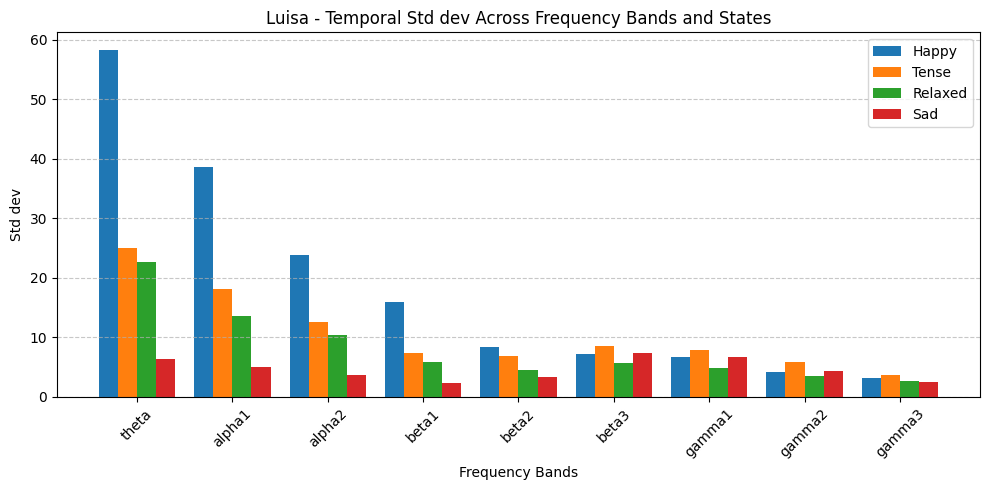

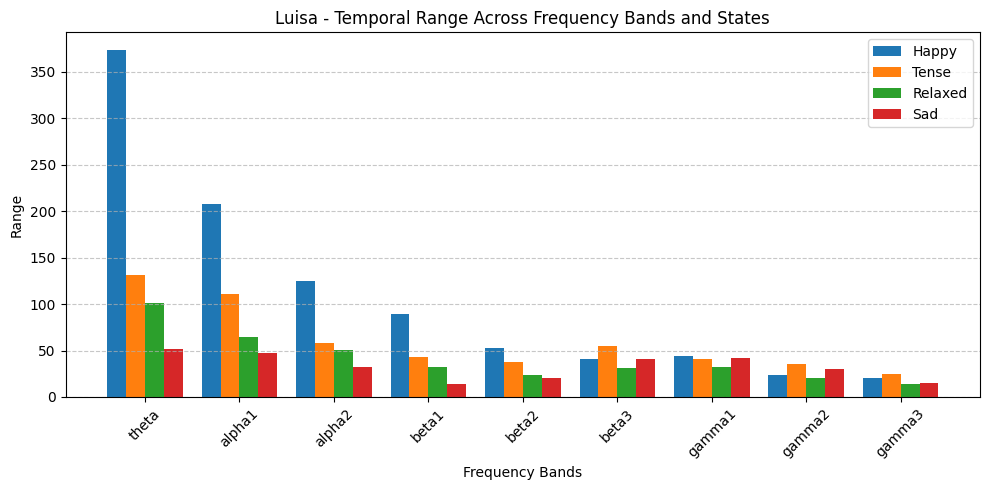

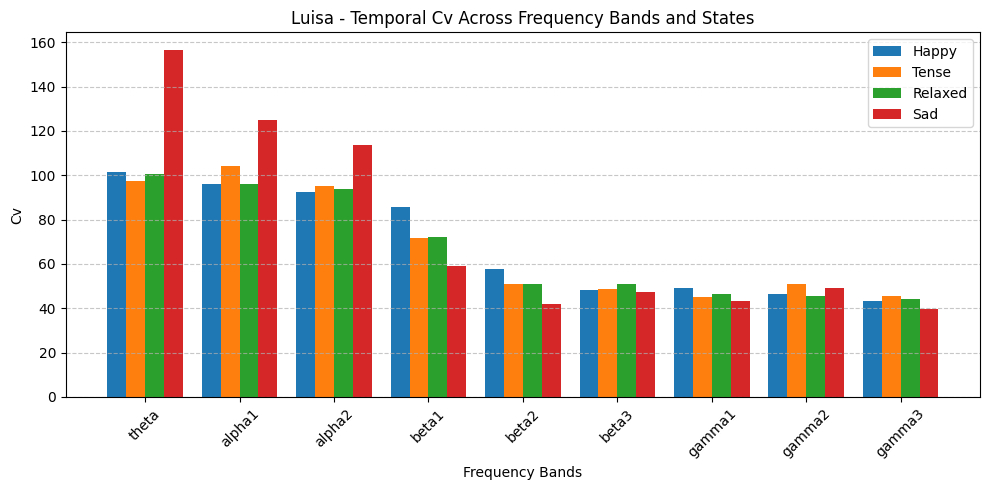

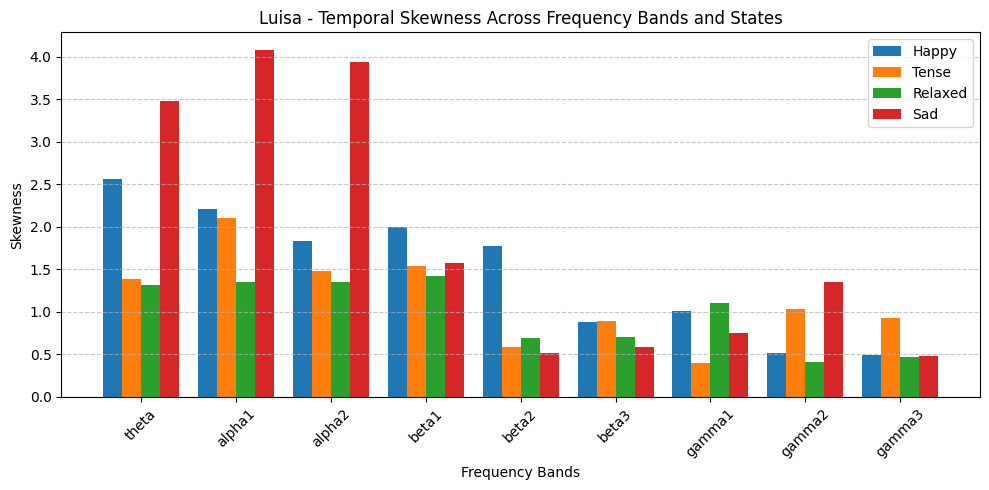

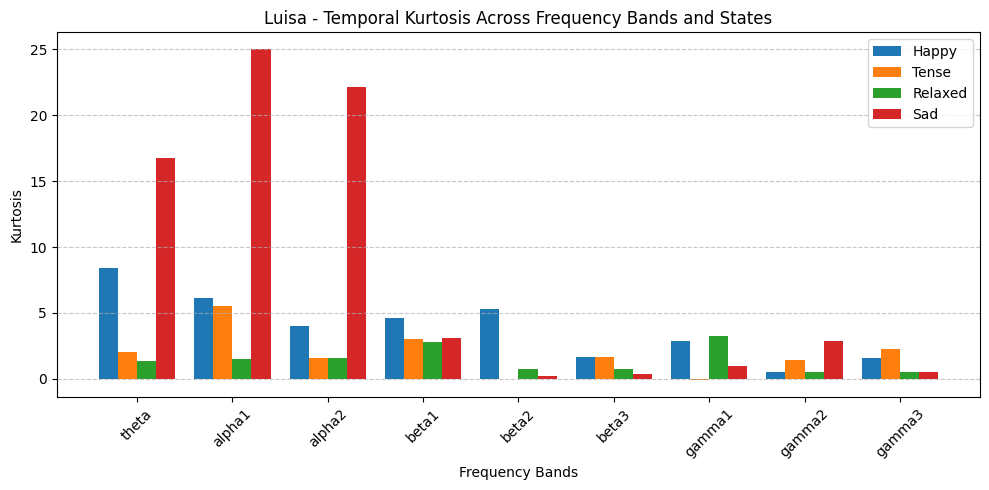

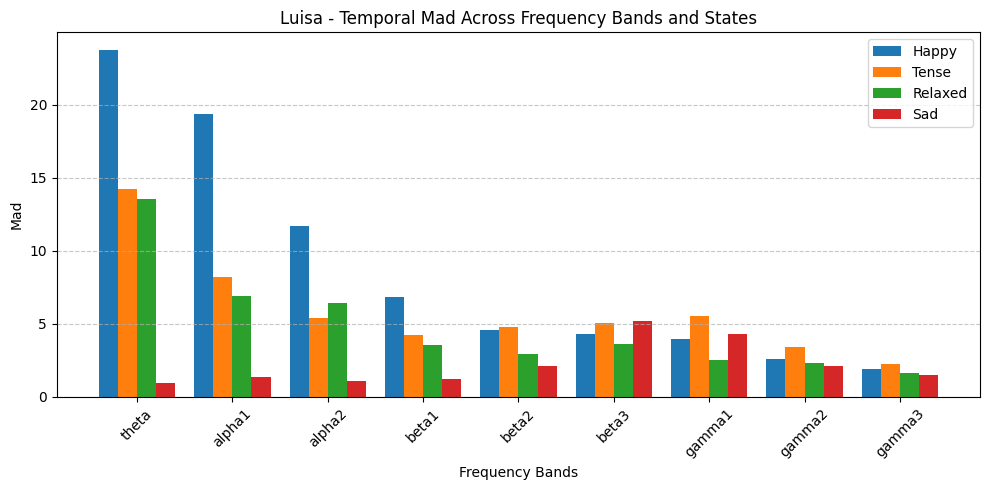

In [26]:
# # Plot additional temporal variability metrics for Luisa

luisa_temporal_metrics = calc_temporal_metrics(luisa_data_rm,nperseg=int(fs),fs=fs)
plot_temporal_metrics(luisa_temporal_metrics,name='Luisa')

In [27]:
# # Create function for calculating band power ratios (beta/alpha, gamma/alpha)

luisa_avg_band_power = calc_avg_band_power(luisa_data_rm,nperseg=int(fs))
print(luisa_avg_band_power['Happy'].keys())

def calc_band_power_ratios(subject_state_avg_power):

    copy_state_avg_power = copy.deepcopy(subject_state_avg_power)

    for state in copy_state_avg_power.keys():
        copy_state_avg_power[state]['alpha'] = np.mean([copy_state_avg_power[state]['alpha1'],copy_state_avg_power[state]['alpha2']])
        copy_state_avg_power[state]['beta'] = np.mean([copy_state_avg_power[state]['beta1'],
                                                          copy_state_avg_power[state]['beta2'],copy_state_avg_power[state]['beta3']])
        copy_state_avg_power[state]['gamma'] = np.mean([copy_state_avg_power[state]['gamma1'],
                                                           copy_state_avg_power[state]['gamma2'],copy_state_avg_power[state]['gamma3']])

    band_power_ratios = {state: {} for state in copy_state_avg_power.keys()}

    sub_bands = ['beta','beta1','beta2','beta3','gamma','gamma1','gamma2','gamma3']

    for state in band_power_ratios.keys():
        for band in sub_bands:
            band_ratio = f'{band}/alpha'
            band_power_ratios[state][band_ratio] = copy_state_avg_power[state][band]/copy_state_avg_power[state]['alpha']


    return band_power_ratios

dict_keys(['theta', 'alpha1', 'alpha2', 'beta1', 'beta2', 'beta3', 'gamma1', 'gamma2', 'gamma3'])


In [28]:
def plot_band_ratio_heatmap(subject_band_ratios, name):
    df = pd.DataFrame(subject_band_ratios).T 
    fig,ax = plt.subplots(figsize=(10,5))
    sns.heatmap(df, annot=True, cmap="viridis", fmt=".2f")
    ax.set(title=f"{name}'s Band Power Ratios Heatmap - Right Mastoid",
           xlabel="Frequency Bands",ylabel="States")
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

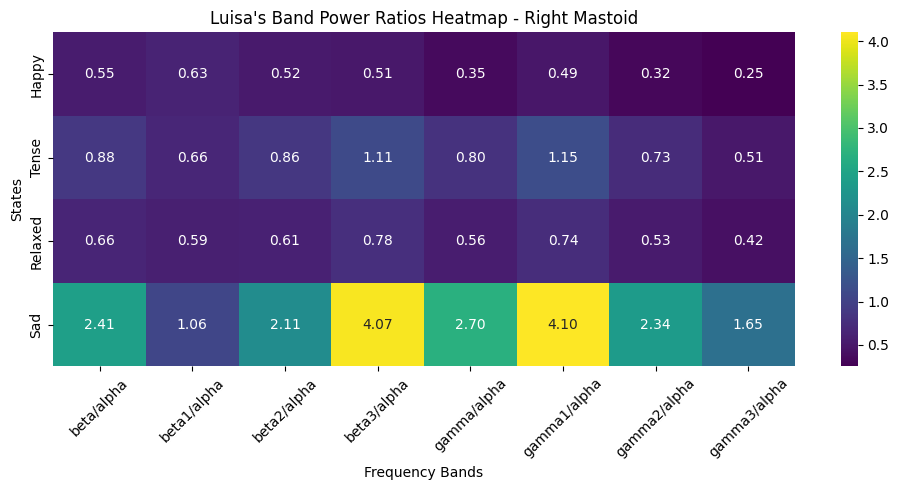

In [29]:
# # Obtain band power ratios for Luisa and plot on Heatmap
luisa_band_power_ratios = calc_band_power_ratios(luisa_avg_band_power)
plot_band_ratio_heatmap(luisa_band_power_ratios,name='Luisa')

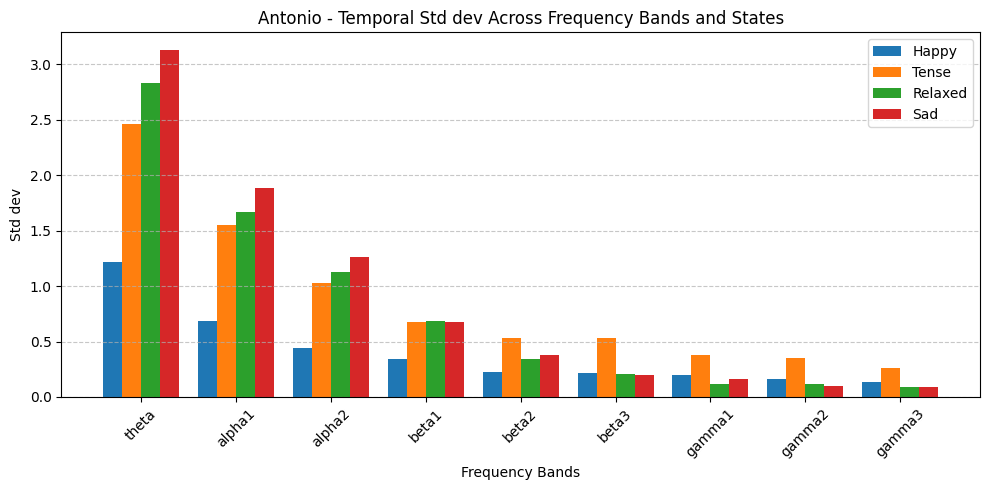

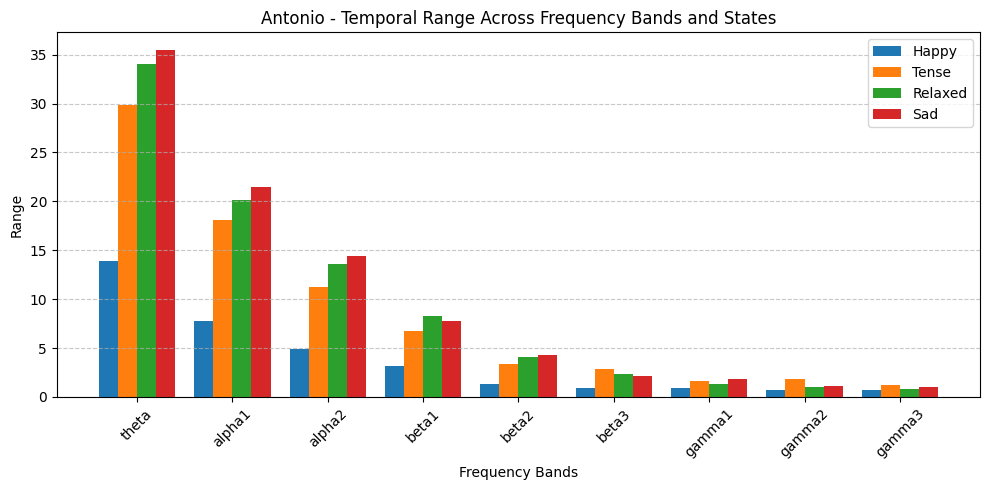

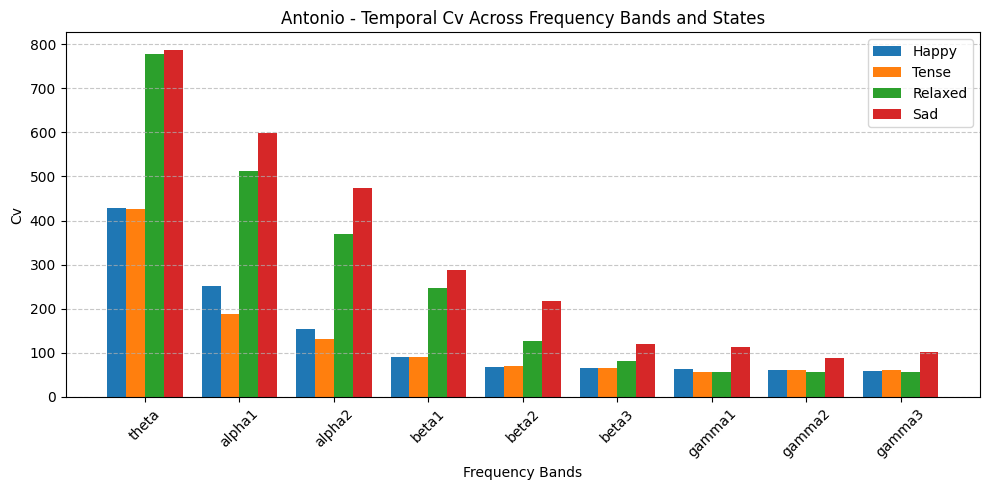

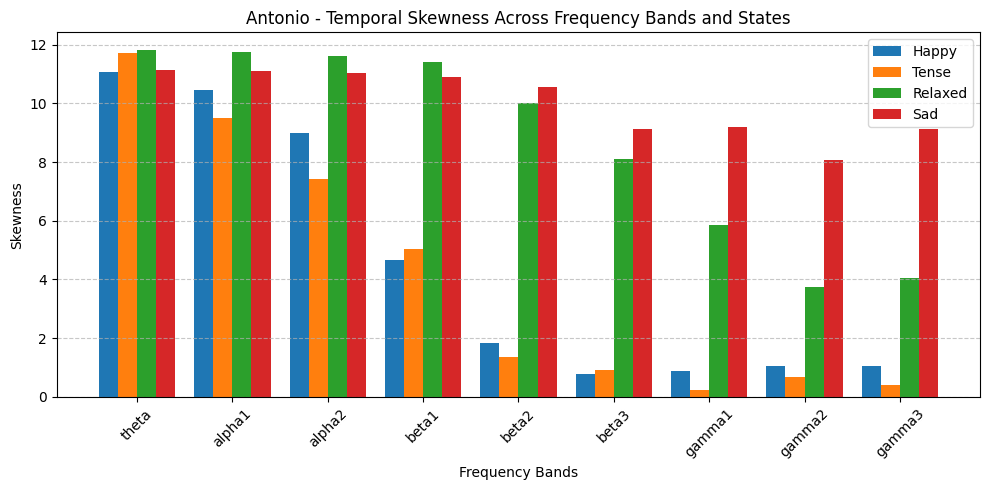

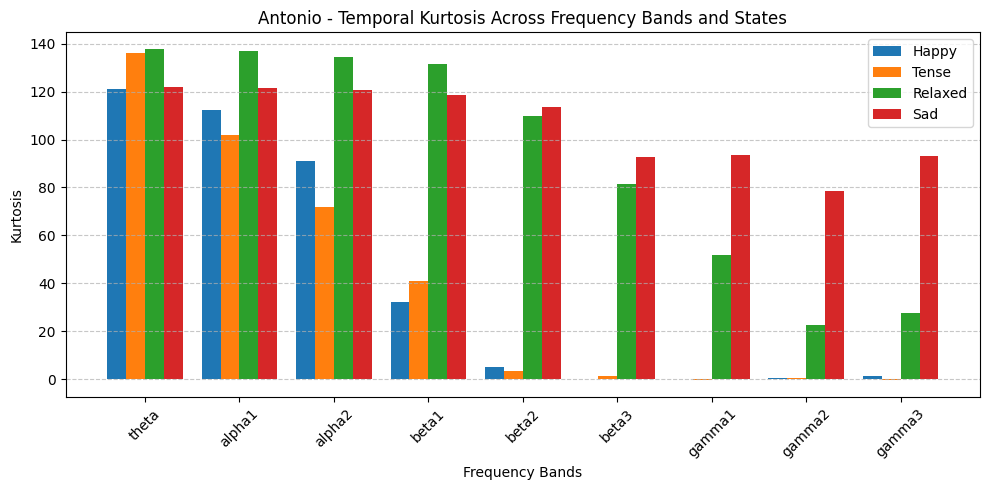

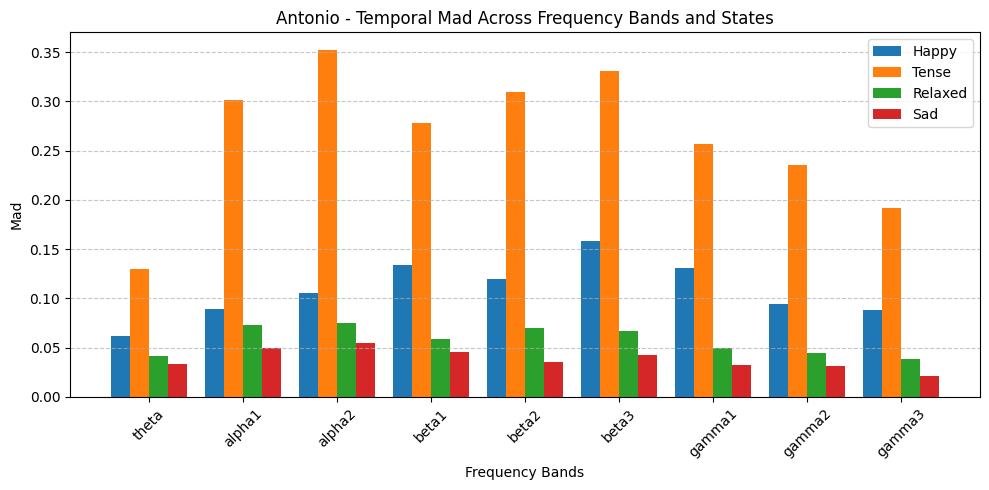

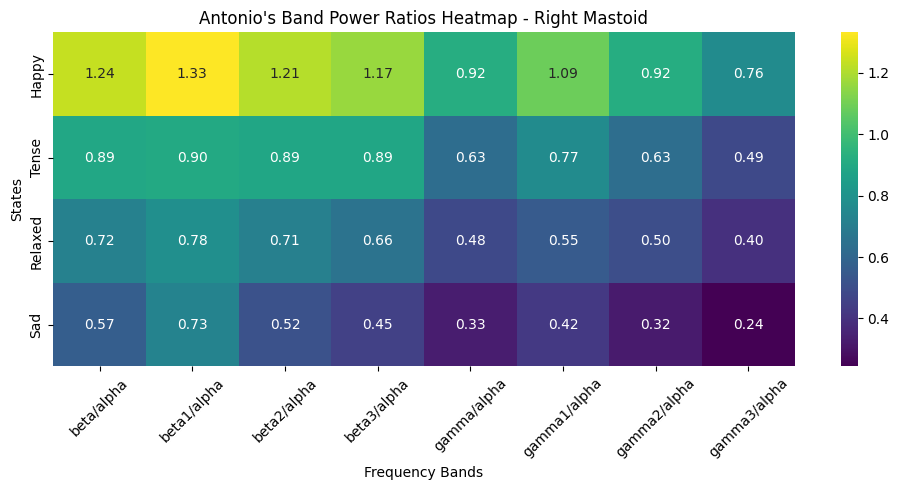

In [30]:
# # Temporal Variability Metrics for Antonio

antonio_temporal_metrics = calc_temporal_metrics(antonio_data_rm,nperseg=int(fs),fs=fs)
plot_temporal_metrics(antonio_temporal_metrics,name='Antonio')

# # Obtain band power ratios for Antonio and plot on Heatmap
antonio_band_power_ratios = calc_band_power_ratios(antonio_avg_band_power)
plot_band_ratio_heatmap(antonio_band_power_ratios,name='Antonio')



# Apply roling (moving average) filter to time series data for smoothing

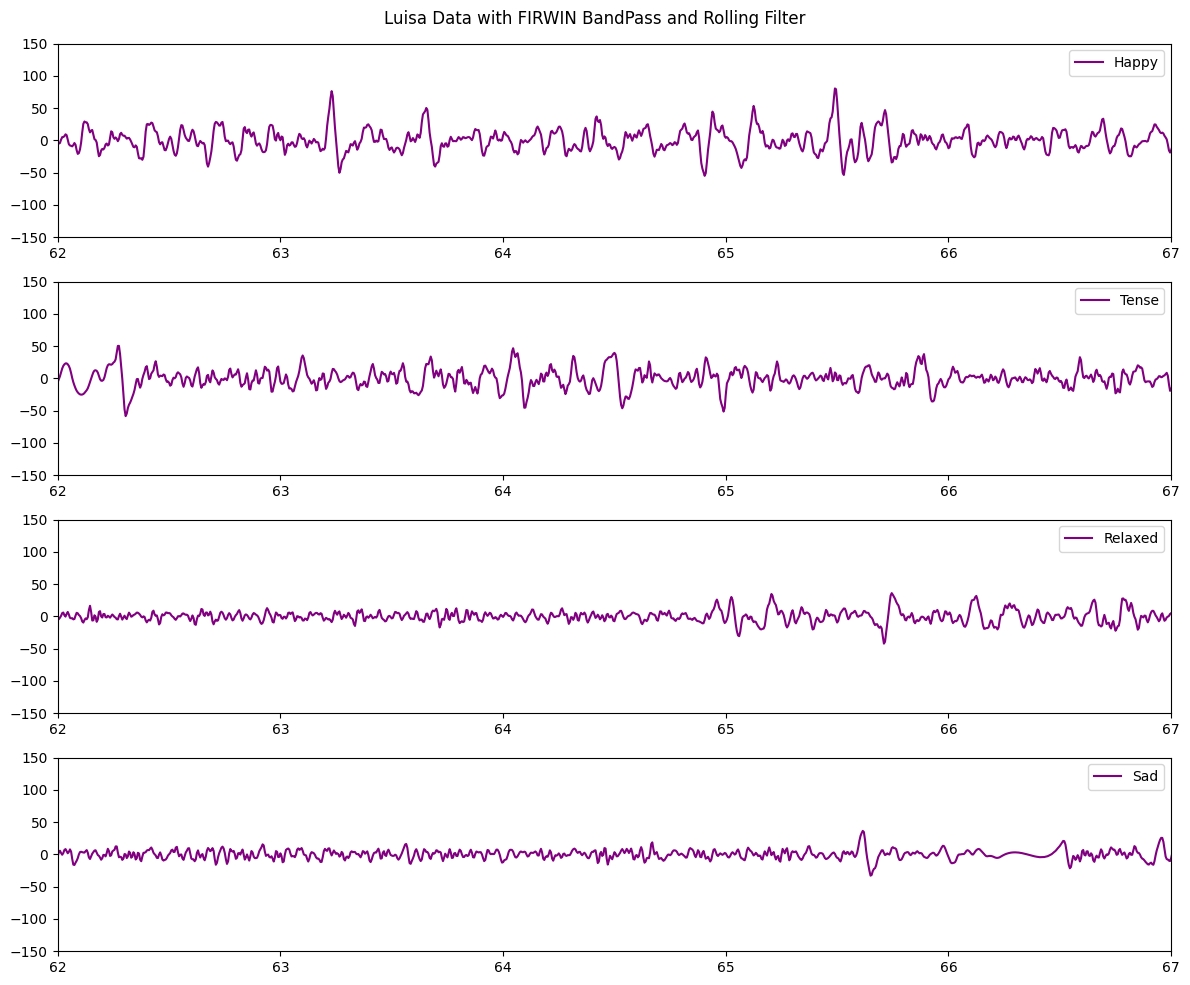

In [43]:
# Apply a rolling (moving average) filter to Luisa Data
def smooth_signal(data, window_size=6):
    return uniform_filter1d(data, size=window_size)

#print(luisa_data_rm['Happy'].shape)

luisa_data_rm_roll = {state : smooth_signal(luisa_data_rm[state]) for state in luisa_data_rm.keys()} # chop out first 2 seconds
#t_vect = np.arange(2, luisa_data_rm_roll['Happy'].size/fs, 1/fs) 

# for state,data in luisa_data_rm_roll.items():
#     print(data.shape)

fig,ax = plt.subplots(4,1,figsize=(12,10))

for i, (state,data) in enumerate(luisa_data_rm_roll.items()):
    t_vect = np.arange(2, data.size/fs, 1/fs)
    ax[i].plot(t_vect,data[2*fs:], label=f"{state}", color='purple', lw=1.5)
    ax[i].set(xlim=[62,67], ylim=[-150,150])
    ax[i].legend()
fig.suptitle('Luisa Data with FIRWIN BandPass and Rolling Filter')
plt.tight_layout()
plt.show()


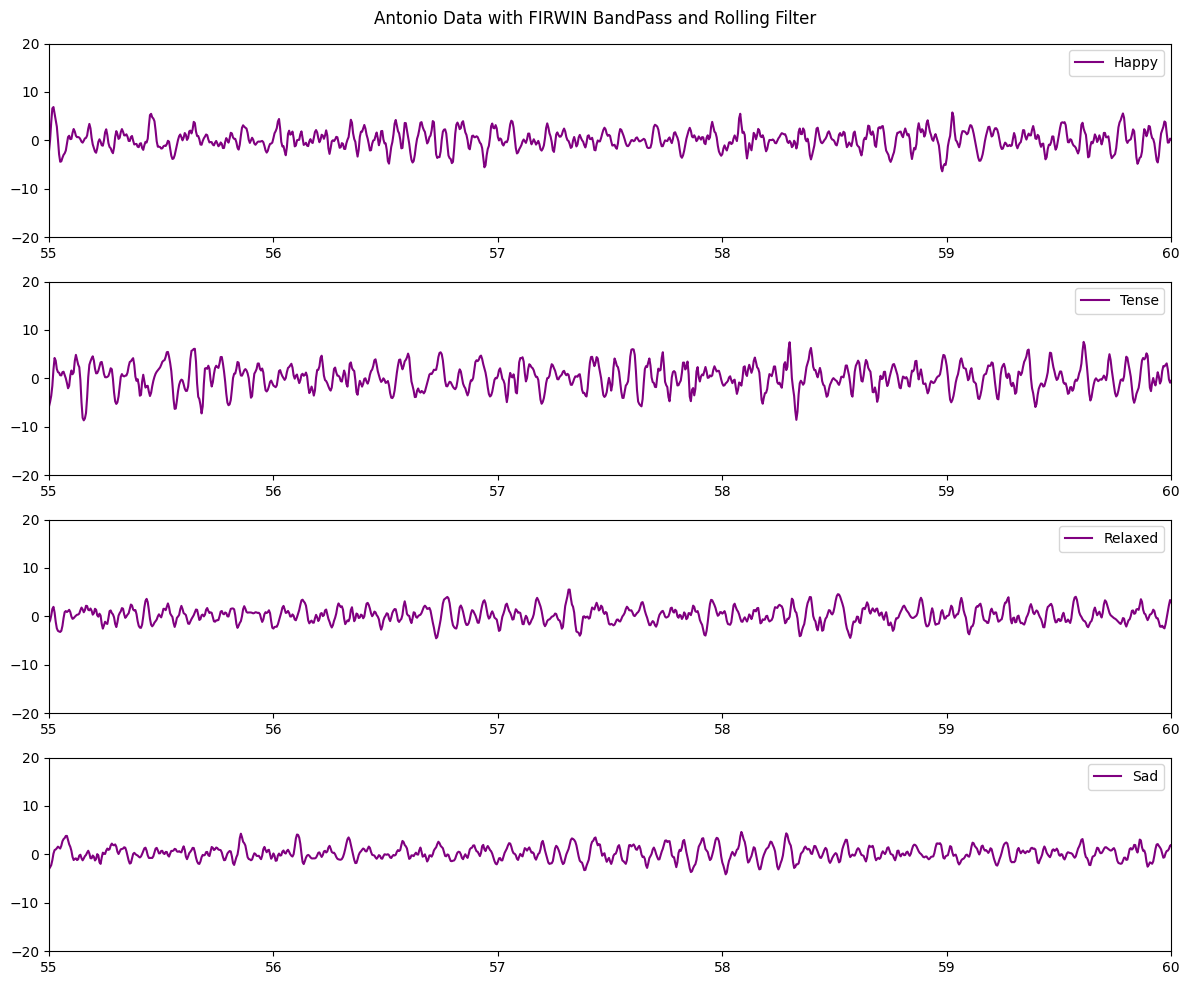

In [39]:
# # Apply rolling filter to Antonio Data

antonio_data_rm_roll = {state : smooth_signal(antonio_data_rm[state]) for state in antonio_data_rm.keys()} # chop out first 2 seconds

fig,ax = plt.subplots(4,1,figsize=(12,10))

for i, (state,data) in enumerate(antonio_data_rm_roll.items()):
    t_vect = np.arange(2, data.size/fs, 1/fs)
    ax[i].plot(t_vect,data[2*fs:], label=f"{state}", color='purple', lw=1.5)
    ax[i].set(xlim=[55,60], ylim=[-20,20])
    ax[i].legend()
fig.suptitle('Antonio Data with FIRWIN BandPass and Rolling Filter')
plt.tight_layout()
plt.show()

# *Appendix*

In [32]:
# luisa_t = {'Happy':[],
#               'Relaxed':[],
#               'Tense':[],
#               'Sad':[]}

# for state, _ in luisa_t.items():
#     luisa_t[state] = np.arange(0,luisa_data[state].shape[1]/fs,1/fs)  # this is a dict containing all t_vectors for luisa data, use for pipeline

# # # Create time vector for happy data
# t_hd = np.arange(0,luisa_data['Happy'].shape[1]/fs,1/fs)

# # plot data in time-domain
# fig1,ax = plt.subplots(2,1, figsize=(7,5))

# for i, ch in enumerate(luisa_data['Happy']):
#     ax[0].plot(t_hd,ch, label=(f'Channel {channels[i]}'))
# ax[0].set(title='Time-Domain Plot Luisa Happy Data', xlabel='Time (s)',ylabel='Voltage (uV)')
# ax[0].set(xlim=[0,t_hd[-1]])

# # Plot data in frequency-domain 
# for ch in luisa_data['Happy']:
#     ft = abs(rfft(ch))
#     ps = ft**2
#     ax[1].plot(rfftfreq(ch.size,d=1/fs), ps) # FFT size is size of each ch which is 18,883. Bc I used rFFT, output contains 9442 freq bins, corresponding to half the FFT size plus one for real-valued input data
# ax[1].set(title='Power Spectrum Plot Luisa Happy Data', xlabel='Frequency (Hz)',ylabel='Power')
# ax[1].set(xlim=[4,60])#,ylim=[0,None])
# ax[1].set_yscale('log')

# fig1.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), shadow=True)
# plt.tight_layout()
# plt.show()

############################################################################################################

# # Plot STFT of only Mastoid Region Channel

# # Create function to display STFT for each channel in each state

# def plot_rmastoid_stft(data,name,nperseg,vmax,fs=fs):

#     n_states = len(data)   
#     n_channels = len(next(iter(data.values())))

#     fig,ax = plt.subplots(1,4,figsize=(20,4))
#     fig.suptitle(f"{name}'s Time-Frequency (STFT) Plot for Right Mastoid Channel", fontsize=10,fontweight='bold')


#     # Plot the STFT for channel 0 - mastoid region
#     for col, (state, ch) in enumerate(data.items()):
#         f_spg,t_spg,spg = signal.spectrogram(x=ch,nperseg=nperseg,noverlap=int(0.25*nperseg),fs=fs)

#         cb = ax[col].pcolormesh(t_spg,f_spg,spg, shading='auto',cmap='viridis',vmin=0,vmax=vmax)
#         ax[col].set(title=f'{state}',xlabel='Time (s)',
#                           ylabel='Frequency (Hz)',ylim=[4,55])
    
#         if col == 3:
#             plt.colorbar(cb, ax=ax[col], label='Power')
    
#     plt.tight_layout()
#     plt.show()

############################################################################################################

